# Libraries

In [1]:
# General use
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Utilities
from lib.utils.url_parsers import extract_host, extract_headline
from lib.utils.constants import event_code_map, geo_type_code_map, country_code_map, role_code_map, country_role_code_map, gov_arm_code_map, country_gov_arm_code_map
from lib.utils.data_loaders import load_data

# Notebook behavior
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pprint
seed = 19  # Replicability


# Exploration

In [2]:
# GDELT 2.0 Documentation: https://blog.gdeltproject.org/gdelt-2-0-our-global-world-in-realtime/
# GDELT Event Codebook: http://data.gdeltproject.org/documentation/GDELT-Event_Codebook-V2.0.pdf
# GDELT Event Code: https://www.gdeltproject.org/data/lookups/CAMEO.eventcodes.txt
fnames = [
    "bq-results-20231121-053647-1700545186575.csv", 
    "bq-results-20231121-055036-1700546053474.csv"
]
dfs = []
for fname in fnames:
    dfs.append(load_data(f"../data/{fname}", kwargs={"dtype":{"EventCode":str, "EventRootCode":str ,"EventBaseCode":str, "GLOBALEVENTID":str, "Actor1Geo_Type":str, "Actor2Geo_Type":str}}))
    
df = pd.concat(dfs).drop_duplicates()
df.columns = df.columns.map(lambda name: name.lower())
df.shape ; del fnames ; del dfs

(973497, 28)

In [3]:
# Limit data to 1 year-- Nov 2022 - Oct 2023
df = df[(df["eventdate"]>=20221101) & (df["eventdate"]<20231101)]
df.shape

(393329, 28)

In [4]:
# Set index
assert df["globaleventid"].nunique() == df.shape[0]
df = df.set_index("globaleventid")
df.to_parquet("../data/phl_relevant_gdelt_events_Nov2022_Oct2023.parquet", compression="gzip", index=True) # Export
df.head(10)  # Preview data

,isrootevent,year,eventdate,eventfractiondate,actor1code,actor1knowngroupcode,actor1countrycode,actor1name,actor1geo_type,actor1geo_fullname,...,eventrootcode,eventbasecode,eventcode,goldsteinscale,nummentions,numsources,numarticles,avgtone,dateadded,sourceurl
globaleventid,,,,,,,,,,,,,,,,,,,,,
1084635672,1,2023,20230213,2023.1178,IND,NaN,IND,HINDUSTAN,4,"Moscow, Moskva, Russia",...,06,061,061,6.4,4,1,4,-1.671309,20230213081500,https://tribune.com.pk/story/2400911/india-aim...
1084635914,1,2023,20230213,2023.1178,PAK,NaN,PAK,PAKISTAN,4,"Moscow, Moskva, Russia",...,06,061,061,6.4,4,1,4,-1.671309,20230213081500,https://tribune.com.pk/story/2400911/india-aim...
1084624061,1,2023,20230213,2023.1178,USA,NaN,USA,UNITED STATES,1,United States,...,02,020,020,3.0,4,1,4,-5.633803,20230213060000,http://www.chinaview.cn/asiapacific/20230213/7...
1084606806,1,2023,20230213,2023.1178,PHL,NaN,PHL,MANILA,4,"Manila, Manila, Philippines",...,03,030,030,4.0,7,1,7,3.118503,20230213013000,https://www.pna.gov.ph/articles/1195023
1084642560,1,2023,20230213,2023.1178,JPN,NaN,JPN,JAPAN,1,Japan,...,04,043,043,2.8,2,1,2,4.651163,20230213093000,https://www.ttgasia.com/2023/02/13/japanese-st...
1084622756,1,2023,20230213,2023.1178,PHL,NaN,PHL,PHILIPPINE,4,"Manila, Manila, Philippines",...,11,112,112,-2.0,1,1,1,-2.967359,20230213054500,https://ground.news/article/philippines-china-...
1084675368,1,2023,20230213,2023.1178,NaN,NaN,NaN,NaN,0,NaN,...,04,040,040,1.0,1,1,1,0.719424,20230213140000,https://www.pna.gov.ph/articles/1195131
1084717942,0,2023,20230213,2023.1178,PHLCOP,NaN,PHL,PHILIPPINE,1,Philippines,...,01,010,010,0.0,2,1,2,-5.093834,20230213190000,https://www.bristolpost.co.uk/news/bristol-new...
1084675199,1,2023,20230213,2023.1178,UKRGOV,NaN,UKR,UKRAINE,1,Ukraine,...,04,041,041,1.0,6,1,6,3.947368,20230213133000,https://www.5.ua/svit/persha-v-istorii-dvostor...


In [5]:
# Mentions data
mentions = load_data("../data/bq-results-20231121-133711-1700573955621.csv", kwargs={"dtype":{"GLOBALEVENTID":str}})
mentions.columns = mentions.columns.map(lambda name: name.lower())
mentions.shape

(1597806, 9)

In [6]:
# Note: Mentions was extracted >6 hours after events hence the higher nunique
mentioned_events = set(mentions["globaleventid"].values)
master_events = set(df.index.values)
print(f"{len(mentioned_events)=}, {len(master_events)=}")
assert len(mentioned_events.intersection(master_events)) == len(master_events)

len(mentioned_events)=974143, len(master_events)=393329


In [7]:
# Retain mentions for relevant events
mentions = mentions[mentions["globaleventid"].isin(df.index)]
mentions.shape

(655605, 9)

In [8]:
# Percentage of events mentioned by outlets
tot_events = mentions["globaleventid"].nunique()
high_coverage_sources = mentions.groupby("mentionsourcename")["globaleventid"].nunique().sort_values(ascending=False)
high_coverage_sources.div(tot_events).head(10)

mentions[mentions["mentionsourcename"].isin(high_coverage_sources[:10].index.tolist())]["globaleventid"].nunique() / tot_events

mentionsourcename
philstar.com             0.128330
inquirer.net             0.120581
manilatimes.net          0.092894
mb.com.ph                0.055679
cnnphilippines.com       0.039125
rappler.com              0.036166
tribune.net.ph           0.030822
sunstar.com.ph           0.029957
businessmirror.com.ph    0.024821
msn.com                  0.023850
Name: globaleventid, dtype: float64

0.5452941430710677

In [9]:
# Describe
def describe_data(data):
    desc = pd.DataFrame({"sparsity":data.isna().mean()})
    desc = desc.merge(data.describe().T, how="left", left_index=True, right_index=True)
    desc = desc.drop(columns=["count"])
    try:
        desc["pct"] = desc["freq"].div(data.shape[0])
    except KeyError:
        pass
    return desc.sort_values("sparsity")
describe_data(df.select_dtypes(exclude="O"))
describe_data(df.select_dtypes(include="O"))

,sparsity,mean,std,min,25%,50%,75%,max
isrootevent,0.0,6.326866e-01,4.820735e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
year,0.0,2.022890e+03,3.133959e-01,2.022000e+03,2.023000e+03,2.023000e+03,2.023000e+03,2.023000e+03
eventdate,0.0,2.022956e+07,2.971511e+03,2.022110e+07,2.023030e+07,2.023052e+07,2.023082e+07,2.023103e+07
eventfractiondate,0.0,2.023382e+03,2.771002e-01,2.022825e+03,2.023167e+03,2.023395e+03,2.023619e+03,2.023825e+03
quadclass,0.0,1.671763e+00,1.048876e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00
goldsteinscale,0.0,1.110512e+00,4.348416e+00,-1.000000e+01,-4.000000e-01,1.900000e+00,3.400000e+00,1.000000e+01
nummentions,0.0,4.212639e+00,3.656222e+00,1.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00,1.900000e+02
numsources,0.0,1.017352e+00,2.298757e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+01
numarticles,0.0,4.144058e+00,3.511615e+00,1.000000e+00,2.000000e+00,3.000000e+00,6.000000e+00,1.900000e+02
avgtone,0.0,-7.543078e-01,3.939792e+00,-2.857143e+01,-3.375121e+00,-6.079027e-01,1.995565e+00,2.629630e+01


,sparsity,unique,top,freq,pct
actor1geo_type,0.000000,6,4,259985,0.660986
actor2geo_type,0.000000,6,4,226258,0.575239
eventrootcode,0.000000,20,04,109215,0.277668
eventbasecode,0.000000,134,042,36300,0.092289
eventcode,0.000000,217,042,36300,0.092289
sourceurl,0.000000,101912,https://www.philstar.com/happens/932,135,0.000343
actor1code,0.063270,1205,PHL,200489,0.509723
actor1name,0.063270,1930,PHILIPPINE,183485,0.466492
actor1geo_fullname,0.076165,5809,"Philippine, Benguet, Philippines",58247,0.148087
actor2code,0.179453,1198,PHL,151243,0.38452


# Feature Extraction

## Based on url

In [10]:
df["sourceurl"] = df["sourceurl"].str.upper()
df["host"] = df["sourceurl"].str.upper().apply(extract_host)  # Extract host
df["headline"] = df["sourceurl"].apply(extract_headline)  # Extract headline

In [11]:
# Which outlets care about PHL?
# Mostly local with some exceptions (ie: msn)
df["host"].value_counts(normalize=True).cumsum()[:10]

host
PHILSTAR          0.115280
INQUIRER          0.226505
MANILATIMES       0.309789
MB                0.361898
CNNPHILIPPINES    0.398547
RAPPLER           0.431466
SUNSTAR           0.459323
TRIBUNE           0.485909
BUSINESSMIRROR    0.507328
BWORLDONLINE      0.526305
Name: proportion, dtype: float64

In [12]:
# Categorize top outlets as local or international
# Manually inspected top 50 news outlets-- already covers >74% of the dataset at n=50
n = 50
manual_annotation_coveraga_pct = df["host"].value_counts(normalize=True).cumsum()[n]

top_news_outlets = list(df["host"].value_counts(normalize=True)[:n].index)
intl_news_outlets = [
    "MSN", "TRIBUNE", "THESTAR", "BENARNEWS", "YAHOO", 
    "BIGNEWSNETWORK", "TALKVIETNAM", "UCANEWS", "MENAFN", "DAILYEXPRESS", 
    "ASIANEWS", "GULFNEWS", "THEDIPLOMAT", "THEEPOCHTIMES", "GLOBALSECURITY", 
    "ARABNEWS", "IBTIMES", "STRAITSTIMES", "SCMP", "HERITAGE", 
    "THETHAIGER", "INDIATIMES", "RFA", "ALJAZEERA", "LAPRENSALATINA", 
    "TAIPEITIMES", "ASIANJOURNAL", "VIETNAMPLUS"
    #"GLOBALTIMES", "BANGKOKPOST", 
] # Top reporters that are not local news outlets- based on domain knowledge
local_news_outlets = [host for host in top_news_outlets if host not in intl_news_outlets]
local_news_outlets[:5] # 5 samples for local news outlets

# Summary
print(f"{manual_annotation_coveraga_pct=}")
print(f"{len(intl_news_outlets)=}; {len(local_news_outlets)=}")

['PHILSTAR', 'INQUIRER', 'MANILATIMES', 'MB', 'CNNPHILIPPINES']

manual_annotation_coveraga_pct=0.720600311698349
len(intl_news_outlets)=28; len(local_news_outlets)=28


In [13]:
# Read data with summary stats of ph news for each news outlet
news_outlets_ph_reports = pd.read_csv("../data/bquxjob_5566f61b_18bbbf32142.csv").dropna()
news_outlets_ph_reports = news_outlets_ph_reports[news_outlets_ph_reports["tot_phl_relevant"]>0]  # Exclude those that never reported on ph
news_outlets_ph_reports["host_url"] = news_outlets_ph_reports["host_url"].str.upper()

news_outlets_ph_reports["host"] = news_outlets_ph_reports["host_url"].apply(extract_host) # Extract host

# Label host
def label_host(host):
    label = "UNKNOWN"
    if host in local_news_outlets:
        label = "LOCAL"
    if host in intl_news_outlets:
        label = "INTERNATIONAL"
    return label
news_outlets_ph_reports["host_label"] = news_outlets_ph_reports["host"].apply(label_host)

news_outlets_ph_reports.head()

,host_url,tot_phl_relevant,avg_phl_relevant,host,host_label
0,WWW.FOXLA.COM,16,0.000607,FOXLA,UNKNOWN
1,WWW.ACESHOWBIZ.COM,19,0.000890,ACESHOWBIZ,UNKNOWN
2,WWW.PENNLIVE.COM,20,0.000994,PENNLIVE,UNKNOWN
3,WWW.WINNIPEGFREEPRESS.COM,377,0.002976,WINNIPEGFREEPRESS,UNKNOWN
4,UA.KORRESPONDENT.NET,23,0.000262,KORRESPONDENT,UNKNOWN


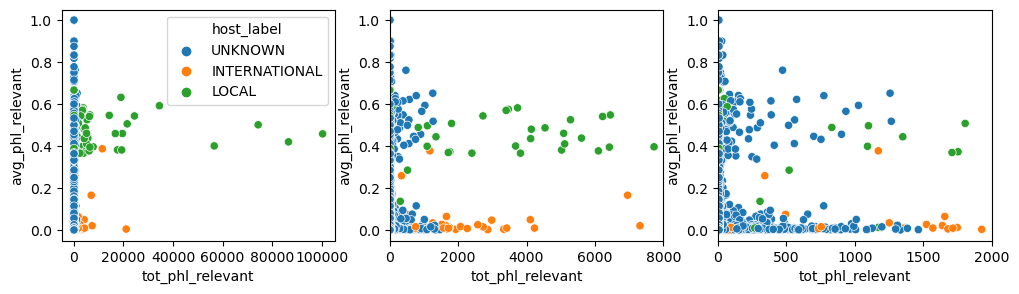

In [14]:
# Visualize: how do known labels compare against others?
kwargs = {"data":news_outlets_ph_reports, "x":"tot_phl_relevant", "y":"avg_phl_relevant", "hue":"host_label"}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

# Visualize full
_ = sns.scatterplot(**kwargs, ax=axes[0])

# Zoom to certain range
_ = sns.scatterplot(**kwargs, ax=axes[1], legend=False)
_ = axes[1].set_xlim(0,8000)

# Zoom closer to certain range
_ = sns.scatterplot(**kwargs, ax=axes[2], legend=False)
_ = axes[2].set_xlim(0,2000)

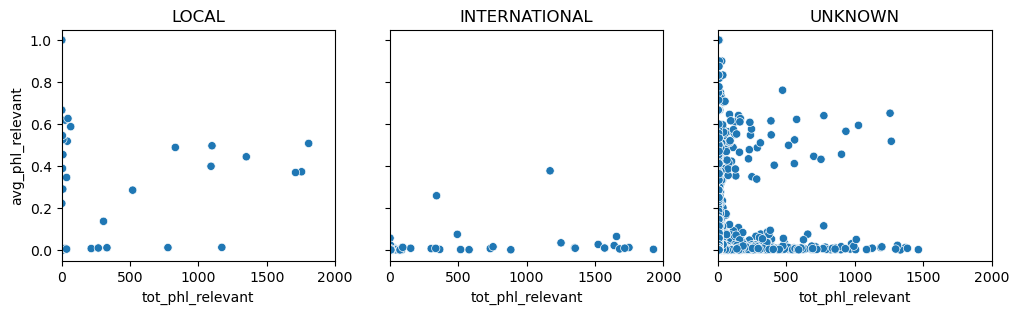

In [15]:
kwargs = {"x":"tot_phl_relevant", "y":"avg_phl_relevant", "hue":"host_label"}
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3), sharex=True, sharey=True)

for i, label in enumerate(["LOCAL", "INTERNATIONAL", "UNKNOWN"]):
    ax = axes[i]
    data = news_outlets_ph_reports[news_outlets_ph_reports["host_label"]==label]
    _ = sns.scatterplot(data=data, **kwargs, ax=ax, legend=False)
    _ = ax.set_title(label)
    _ = ax.set_xlim(0,2000)

### Manual annotation of `host_label`

In [16]:
# Inspect potentially local news networks based on proximity to labelled data
minimum_requirements = "avg_phl_relevant >= 0.3 & host_label == 'UNKNOWN'"
sorted_data = news_outlets_ph_reports.sort_values("tot_phl_relevant", ascending=False)
cols = ["host_url", "host"]

# Reports on ph at least once a day on avg -- confirmed 100% local
sorted_data.query(f"{minimum_requirements} & tot_phl_relevant >= {df.eventdate.nunique()}")[cols]

# Reports on ph [100, once a day on avg) -- confirmed 100% local
sorted_data.query(f"{minimum_requirements} & tot_phl_relevant >= 100 & tot_phl_relevant < {df.eventdate.nunique()}")[cols]

# Reports on ph [50, 100) -- confirmed 100% local
sorted_data.query(f"{minimum_requirements} & tot_phl_relevant >= 50 & tot_phl_relevant < 100")[cols]

,host_url,host
2258,WWW.POSITIVELYFILIPINO.COM,POSITIVELYFILIPINO
760,WWW.GOODNEWSPILIPINAS.COM,GOODNEWSPILIPINAS
1289,PHILIPPINESLIFESTYLE.COM,PHILIPPINESLIFESTYLE
1292,WWW.CONGRESS.GOV.PH,CONGRESS
711,WWW.MANILAMETRO.COM,MANILAMETRO
2291,OUTOFTOWNBLOG.COM,OUTOFTOWNBLOG
3167,PHILKOTSE.COM,PHILKOTSE
1382,BAGUIOMIDLANDCOURIER.COM.PH,BAGUIOMIDLANDCOURIER
1692,MINDANAOEXAMINERNEWSPAPER.BLOGSPOT.COM,MINDANAOEXAMINERNEWSPAPER
3204,WWW.CARGUIDE.PH,CARGUIDE


,host_url,host
1735,GADGETSMAGAZINE.COM.PH,GADGETSMAGAZINE
1167,WWW.TEMPO.COM.PH,TEMPO
2810,WWW.CLICKTHECITY.COM,CLICKTHECITY
2208,WWW.BOMBORADYO.COM,BOMBORADYO
1673,WWW.DAILYPEDIA.NET,DAILYPEDIA
1295,VARSITARIAN.NET,VARSITARIAN
3676,WWW.NOYPIGEEKS.COM,NOYPIGEEKS
3757,PHILNEWS.PH,PHILNEWS
150,TEMPO.COM.PH,TEMPO
2885,POWERPHILIPPINES.COM,POWERPHILIPPINES


,host_url,host
2209,PANAHON.TV,PANAHON
1863,WWW.TRENDING.PH,TRENDING
2739,THELASALLIAN.COM,THELASALLIAN
865,WWW.SHANGBAO.COM.PH,SHANGBAO
2127,WWW.COSMO.PH,COSMO
195,UNBOX.PH,UNBOX
2192,MINDANAOTIMES.COM.PH,MINDANAOTIMES
2680,WWW.SPIN.PH,SPIN
2882,WWW.AUTODEAL.COM.PH,AUTODEAL
3000,WWW.TECHPINAS.COM,TECHPINAS


In [17]:
# Continuation: Inspect potentially local news networks based on proximity to labelled data

# Reports on ph [25, 50)
# Exceptions: ["FT", "NATIONALWW2MUSEUM", "THEASBURYCOLLEGIAN"]
sorted_data.query(f"{minimum_requirements} & tot_phl_relevant >= 25 & tot_phl_relevant < 50")[cols]

# Reports on ph [15, 25)
# Exceptions: ["SANANTONIO", "FAREASTERNAGRICULTURE"]
sorted_data.query(f"{minimum_requirements} & tot_phl_relevant >= 15 & tot_phl_relevant < 25")[cols]

# Reports on ph [10, 15)
# Exceptions: ["MYMCMURRAY", "UBYSSEY", "PROPERTY-REPORT", "SOPERTH", "COOLBUSTER", "RIOTGAMES", "WORLD-NUCLEAR"]
sorted_data.query(f"{minimum_requirements} & tot_phl_relevant >= 10 & tot_phl_relevant < 15")[cols]

,host_url,host
680,POLITICS.COM.PH,POLITICS
810,JAMONLINE.PH,JAMONLINE
3780,WWW.TRIPZILLA.PH,TRIPZILLA
962,IG.FT.COM,FT
2717,WWW.CDODEV.COM,CDODEV
961,WWW.8LIST.PH,8LIST
1700,WWW.DEPED.GOV.PH,DEPED
2400,NYLONMANILA.COM,NYLONMANILA
1864,WWW.NATIONALWW2MUSEUM.ORG,NATIONALWW2MUSEUM
732,WWW.UNGEEK.PH,UNGEEK


,host_url,host
2262,WWW.UP.EDU.PH,UP
2590,WWW.SANANTONIO.GOV,SANANTONIO
3315,WWW.MANILASTANDARDTODAY.COM,MANILASTANDARDTODAY
3718,WWW.KATHRIVERA.COM,KATHRIVERA
196,OPS.GOV.PH,OPS
1192,FAREASTERNAGRICULTURE.COM,FAREASTERNAGRICULTURE
2093,MINDANAOEXAMINER.COM,MINDANAOEXAMINER
404,MEGA.ONEMEGA.COM,ONEMEGA
3078,NEGROSCHRONICLE.COM,NEGROSCHRONICLE
1166,WWW.WINDOWSEAT.PH,WINDOWSEAT


,host_url,host
1039,WWW.MYMCMURRAY.COM,MYMCMURRAY
3099,WWW.SMARTPARENTING.COM.PH,SMARTPARENTING
3217,WWW.POLITICS.COM.PH,POLITICS
2194,UBYSSEY.CA,UBYSSEY
2482,WWW.PROPERTY-REPORT.COM:80,PROPERTY-REPORT
1777,SOPERTH.COM.AU,SOPERTH
3188,WWW.COOLBUSTER.NET,COOLBUSTER
1398,WWW.RIOTGAMES.COM,RIOTGAMES
3298,WWW.RAISSAROBLES.COM,RAISSAROBLES
3130,NEWPHILREVOLUTION.BLOGSPOT.COM,NEWPHILREVOLUTION


In [18]:
# Continuation: Inspect potentially local news networks based on proximity to labelled data

# Reports on ph [5, 10)
# Exceptions: ["SASKPOLYTECH", "MADISONPARKTIMES", "THOIBAO", "SDCOE", "KLGADGETGUY", "THEINTERIORSADDICT", "R744", "KONFRONTASI", "COSMOPOLITAN", "LDSVOICES"]
sorted_data.query(f"{minimum_requirements} & tot_phl_relevant >= 5 & tot_phl_relevant < 10")[cols]

# Reports on ph [1, 5)
# Exceptions: ["NOCUTNEWS", "NAFTIKACHRONIKA", "CLEANROOMTECHNOLOGY", "FIRSTWEFEAST", "BANFFCENTRE", "ALLSBC", "OPENSTREETMAP", "TYPEPAD", "TOPAISOFTWARE", "NEGOSENTRO", "THEMOMEDIT", "UAI", "24-7PRESSRELEASE"]
# At this range, the most useful indicator is the suffix ".ph". Without that, we'll assume it's an internationl outlet
sorted_data.query(f"{minimum_requirements} & tot_phl_relevant >=2 & tot_phl_relevant < 5")[cols]

,host_url,host
1320,SASKPOLYTECH.CA,SASKPOLYTECH
1396,MADISONPARKTIMES.COM,MADISONPARKTIMES
3150,WWW.THOIBAO.COM,THOIBAO
58834,WWW.SDCOE.NET,SDCOE
59014,WWW.UNBOX.PH,UNBOX
58997,WWW.GOSPEL900.COM,GOSPEL900
58631,WWW.PINOYTECHBLOG.COM,PINOYTECHBLOG
58599,KLGADGETGUY.COM,KLGADGETGUY
58395,THEINTERIORSADDICT.COM,THEINTERIORSADDICT
58670,PINOYTECHBLOG.COM,PINOYTECHBLOG


,host_url,host
56873,M.NOCUTNEWS.CO.KR,NOCUTNEWS
56833,WWW.ALABANGBULLETIN.COM,ALABANGBULLETIN
56990,WWW.REMATE.PH,REMATE
57297,WWW.NAFTIKACHRONIKA.GR,NAFTIKACHRONIKA
57331,PNP.GOV.PH,PNP
56286,WWW.AKSYONRADYOILOILO.COM.PH,AKSYONRADYOILOILO
56255,WWW.JTEXPRESS.PH,JTEXPRESS
56495,WWW.FASHIONPULIS.COM,FASHIONPULIS
56311,WWW.FLIPSCIENCE.PH,FLIPSCIENCE
56431,CLEANROOMTECHNOLOGY.COM,CLEANROOMTECHNOLOGY


In [19]:
# Relabel based on findings
additional_intl_news_outlets = [
    "FT", "NATIONALWW2MUSEUM", "THEASBURYCOLLEGIAN", "SANANTONIO", "FAREASTERNAGRICULTURE", 
    "MYMCMURRAY", "UBYSSEY", "PROPERTY-REPORT", "SOPERTH", "COOLBUSTER", 
    "RIOTGAMES", "WORLD-NUCLEAR", "SASKPOLYTECH", "MADISONPARKTIMES", "THOIBAO", 
    "SDCOE", "KLGADGETGUY", "THEINTERIORSADDICT", "R744", "KONFRONTASI", 
    "COSMOPOLITAN", "LDSVOICES", "NOCUTNEWS", "NAFTIKACHRONIKA", "CLEANROOMTECHNOLOGY", 
    "FIRSTWEFEAST", "BANFFCENTRE", "ALLSBC", "OPENSTREETMAP", "TYPEPAD", 
    "TOPAISOFTWARE", "NEGOSENTRO", "THEMOMEDIT", "UAI", "24-7PRESSRELEASE"
]
def relabel_host(row):
    label = row.host_label
    if label=="UNKNOWN" and row.avg_phl_relevant >= 0.3:
        if row.tot_phl_relevant >= 15:
            if row.host in additional_intl_news_outlets:
                label = "INTERNATIONAL"
            else:
                label = "LOCAL"
        else:
            if str(row.host_url).endswith(".PH"):
                label = "LOCAL"
    return label

news_outlets_ph_reports["host_relabel"] = news_outlets_ph_reports.apply(relabel_host, axis=1)
news_outlets_ph_reports.groupby(["host_label", "host_relabel"])["host"].nunique()

host_label     host_relabel 
INTERNATIONAL  INTERNATIONAL      28
LOCAL          LOCAL              28
UNKNOWN        INTERNATIONAL       5
               LOCAL              79
               UNKNOWN          8429
Name: host, dtype: int64

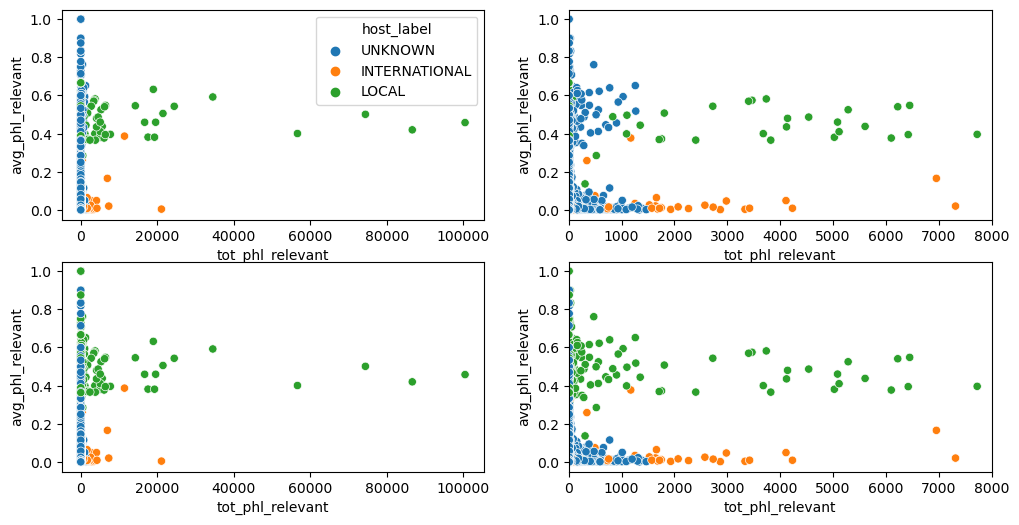

In [20]:
# Updated
# Visualize: how do known labels compare against others?
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

# Old labels
kwargs = {"data":news_outlets_ph_reports, "x":"tot_phl_relevant", "y":"avg_phl_relevant", "hue":"host_label"}
_ = sns.scatterplot(**kwargs, ax=axes[0,0])
_ = sns.scatterplot(**kwargs, ax=axes[0,1], legend=False)
_ = axes[0,1].set_xlim(0,8000)

# New labels
kwargs = {"data":news_outlets_ph_reports, "x":"tot_phl_relevant", "y":"avg_phl_relevant", "hue":"host_relabel"}
_ = sns.scatterplot(**kwargs, ax=axes[1,0], legend=False)
_ = sns.scatterplot(**kwargs, ax=axes[1,1], legend=False)
_ = axes[1,1].set_xlim(0,8000)

In [21]:
# How much of the data do we know after manual annotation?
hosts_with_known_labels = news_outlets_ph_reports[news_outlets_ph_reports["host_relabel"]!="UNKNOWN"]["host"].unique().tolist()
updated_manual_annotation_coveraga_pct = df["host"].isin(hosts_with_known_labels).mean()
print(f"{manual_annotation_coveraga_pct=}")
print(f"{updated_manual_annotation_coveraga_pct=}")
diff = updated_manual_annotation_coveraga_pct - manual_annotation_coveraga_pct ; print(f"{diff=}")

manual_annotation_coveraga_pct=0.720600311698349
updated_manual_annotation_coveraga_pct=0.7487599439654844
diff=0.02815963226713536


In [22]:
# Warning: overrides previous declaration
local_news_outlets = news_outlets_ph_reports[news_outlets_ph_reports["host_relabel"]=="LOCAL"]["host"].unique().tolist()
df["phl_host"] = df["host"].isin(local_news_outlets)

### `headline`

In [23]:
# Inspect frequency of headlines
ser = df["headline"].value_counts()
ser.describe()

count    96499.000000
mean         4.075990
std         10.792004
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       2725.000000
Name: count, dtype: float64

In [24]:
# Inspect insanely common headlines
q1, q3 = np.percentile(ser, [25, 75])
iqr = q3 - q1
upper_lim = iqr + q3 ; upper_lim
ser[ser > upper_lim].head(20)

9.0

headline
                                                                                                      2725
C.HTML                                                                                                 938
WORLD                                                                                                  749
FLIGHT TIME                                                                                            227
MEDIA KILLINGS PHILIPPINES COURTS FLOUNDER ARCHIVED DISMISSED                                          178
MEZHDUNARODNAYA PANORAMA                                                                               150
TWO CANADIANS KIDNAPPED AND KILLED IN PHILIPPINES CANADA STILL REFUSES TO NEGOTIATE                    140
2023 01                                                                                                135
932                                                                                                    135
VP HARRIS URGES DEFENSE OF S

In [25]:
# Exceptions
php_aspx_mask = df["headline"].str.contains(".PHP?|.ASPX?")
php_aspx_mask.sum(), php_aspx_mask.mean()

num_id_mask = (df["headline"].str.contains("\d{6,}", regex=True)) & (df["headline"].str.len()<=10) & ~php_aspx_mask
num_id_mask.sum(), num_id_mask.mean()

flight_mask = df["headline"].str.contains("FLIGHT")
flight_mask.sum(), flight_mask.mean()

(php_aspx_mask | num_id_mask | flight_mask).mean()  # Total

(73361, 0.18651307175418033)

(6791, 0.017265444449811734)

(2173, 0.0055246371358328526)

0.20826076897457346

In [26]:
# Finding: headlines with many associated events are generic/summaries/timelines
_is_short_headline = df["headline"].isin(ser[ser>upper_lim].index.tolist())
_has_multiple_associated_events = df["headline"].str.split(" ").apply(lambda lst: len(lst)==1)
df["generic_headline"] = _is_short_headline | _has_multiple_associated_events

<div class="alert alert-block alert-info">
    <b>Note:</b> In sample selection, flight records and generic headlines might be considered to be removed.
</div>

from lib.utils.sentence_encoders import encode_sentences
input_sentences = df[~df["generic_headline"]]["headline"].unique().tolist()[:1000]
encodings = encode_sentences(input_sentences, model_name="distilbert-base-uncased")

<div class="alert alert-block alert-danger">
<b>Change Log:</b> Did not proceed with sentence encoding of <code>headline</code> due to computational demands. Kernel crashes.
</div>

df["headline_synthetic"] = (df["actor1name"] + " " + df["eventcode"].map(event_code_to_description_map) + " " + df["actor2name"])
df["headline_synthetic"] = df["headline_synthetic"].str.upper()

print(f"{df.headline.nunique()=}")
print(f"{df.headline_synthetic.nunique()=}")

from lib.utils.sentence_encoders import encode_sentences
input_sentences = df[~df["generic_headline"]]["headline_synthetic"].dropna().unique().tolist()
print(f"{len(input_sentences)=}")
encodings = encode_sentences(input_sentences, model_name="distilbert-base-uncased")

<div class="alert alert-block alert-danger">
<b>Change Log:</b> Did not proceed with sentence encoding of <code>headline_synthetic</code> due to computational demands. Kernel crashes.
</div>

In [27]:
# Describe engineered features
describe_data(df[["host", "headline", "phl_host", "generic_headline"]])  # Describe

,sparsity,unique,top,freq,pct
host,0.0,5534,PHILSTAR,45343,0.11528
headline,0.0,96499,,2725,0.006928
phl_host,0.0,2,True,244527,0.621686
generic_headline,0.0,2,False,241945,0.615121


## Based on eventcode

In [28]:
# Preview
cols = ['eventrootcode', 'eventbasecode', 'eventcode']
df[cols].head()

,eventrootcode,eventbasecode,eventcode
globaleventid,,,
1084635672,06,061,061
1084635914,06,061,061
1084624061,02,020,020
1084606806,03,030,030
1084642560,04,043,043


In [29]:
# Describe
describe_data(df[cols])

,sparsity,unique,top,freq,pct
eventrootcode,0.0,20,04,109215,0.277668
eventbasecode,0.0,134,042,36300,0.092289
eventcode,0.0,217,042,36300,0.092289


In [30]:
# Map event description
df["eventrootdescription"] = df["eventrootcode"].map(event_code_map)
df["eventdescription"] = df["eventcode"].map(event_code_map)
df[["eventrootdescription", "eventdescription"]]

,eventrootdescription,eventdescription
globaleventid,,
1084635672,ENGAGE IN MATERIAL COOPERATION,Cooperate economically
1084635914,ENGAGE IN MATERIAL COOPERATION,Cooperate economically
1084624061,APPEAL,"Appeal, not specified below"
1084606806,EXPRESS INTENT TO COOPERATE,"Express intent to cooperate, not specified below"
1084642560,CONSULT,Host a visit
...,...,...
1084521545,MAKE PUBLIC STATEMENT,"Make statement, not specified below"
1084543958,APPEAL,"Appeal, not specified below"
1084561230,EXPRESS INTENT TO COOPERATE,Express intent to provide diplomatic cooperati...


In [31]:
# Is eventcode and eventbasecode the same? Mostly
mask = df["eventcode"].astype(int) != df["eventbasecode"].astype(int)
mask.mean()
df[mask][cols].head()

0.026064693933068754

,eventrootcode,eventbasecode,eventcode
globaleventid,,,
1084633588,11,112,1123
1084660184,11,112,1123
1084703931,02,021,0211
1084725143,17,171,1712
1084654749,08,084,0841


In [32]:
# Virtually the same except for 2.74% of rows
# We are okay with losing that much information
no_event_code = df["eventcode"].isna()

<div class="alert alert-block alert-info">
    <b>Note:</b> In sample selection, records with no event code will be removed.
</div>

## Based on goldsteinscale

,sparsity,unique,top,freq,pct
impact,0.0,4,SLIGHTLY STABILIZING,203959,0.518546


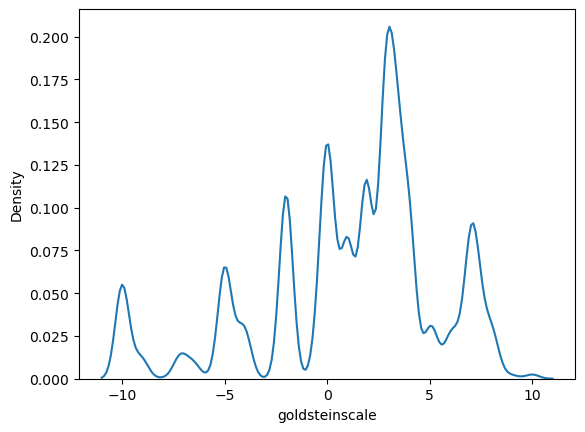

In [33]:
# From the docs: 
# - GoldsteinScale is a numeric score from -10 to +10, capturing the theoretical potential impact that type of event will have on the stability of a country.
# - NOTE: this score is based on the type of event, not the specifics of the actual event record being recorded – thus two riots, one with 10 people and one with 10,000, will both receive the same Goldstein score.
# - Follows a rule-based approach based on CAMEO Event Codes - that is, each event code already has a corresponding Goldstein score for GDELT.
_ = sns.kdeplot(df["goldsteinscale"])

# Derive impact
# Cutoffs based on distribution and eventcode documentation
df["impact"] = pd.cut(df["goldsteinscale"], 
                      bins=[-np.inf,-6,0,6,np.inf], 
                      labels=["DESTABILIZING", "SLIGHTLY DESTABILIZING", "SLIGHTLY STABILIZING", "STABILIZING"])
describe_data(df[["impact"]])  # Describe

<Axes: xlabel='impact', ylabel='eventrootdescription'>

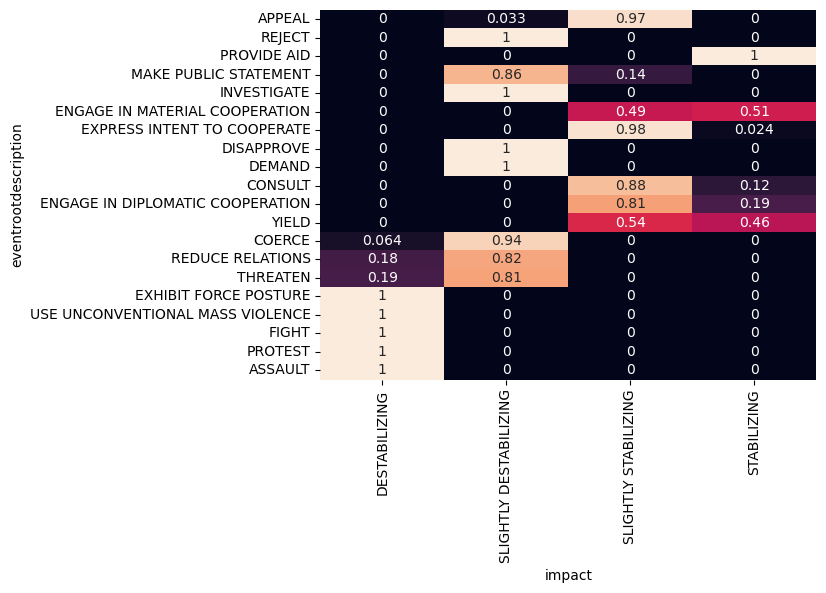

In [34]:
# Kind of events associated to impact labels?
# As expected, moves from chaotic to diplomatic

tmp = df.pivot_table(index="eventrootdescription", columns="impact", values="sourceurl", aggfunc="count")
tmp = tmp.div(tmp.sum(axis=1), axis=0)
sns.heatmap(tmp.sort_values("DESTABILIZING"), cbar=False, annot=True)

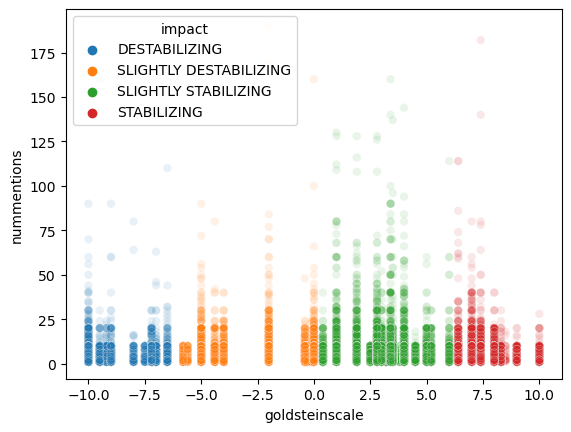

In [35]:
# Do high impact events get more mentions?
# Surprisingly, no
_ = sns.scatterplot(data=df, x="goldsteinscale", y="nummentions", hue="impact", alpha=0.1)

In [36]:
# Percentage that a record is sensationalized based on nummentions
# There is a preference for news networks to reports stabilizing events
thresh = np.percentile(df["nummentions"], 90) ; thresh
df.groupby("impact")["nummentions"].agg(lambda ser: (ser>thresh).mean())

10.0

impact
DESTABILIZING             0.014252
SLIGHTLY DESTABILIZING    0.010703
SLIGHTLY STABILIZING      0.013915
STABILIZING               0.014855
Name: nummentions, dtype: float64

In [37]:
sensationalized = df["nummentions"] >= thresh
sensationalized.mean()  # Pct sensationalized among records

# Sample sensationalized headlines for each impact group
sample_from_series = lambda ser: ser.sample(frac=1, random_state=19).dropna().values.tolist()[:3]
samples = df[sensationalized].groupby("impact")["headline"].agg(sample_from_series).to_dict()
pprint.pprint(samples)

0.11978013317095866

{'DESTABILIZING': ['PHILIPPINE TROOPS KILL 6 SUSPECTED REBELS IN CLASH',
                   'NEAR COLLISION TENSE ENCOUNTER AS BEIJING FLEXES MUSCLES '
                   'IN THE SOUTH CHINA SEA',
                   'VIEW.PHP?UD=20230608000521'],
 'SLIGHTLY DESTABILIZING': ['MAN HELD ROBBERY VIOLATING GUN BAN',
                            'FILIPINY CINA VOJENSKY LASER ZPRAVY ONLINE '
                            'IROZHLAS_2302132252_KTH',
                            'CHINA DOMINIO PAISES VIZINHOS AGUAS DISPUTADAS '
                            'ENTENDA'],
 'SLIGHTLY STABILIZING': ['CEBU CITY BUY BUSTS YIELD P7 5 M SHABU',
                          'PASION SUBLIMADA ARTE 79018272.HTML',
                          'DOH RAMPS UP COVID SURVEILLANCE'],
 'STABILIZING': ['HDMF CITES PA PROPERTIES AMONG TOP DEVELOPERS IN NORTHERN '
                 'LUZON',
                 'LO IBAN LITERALMENTE A CORTAR COMO UN PEDAZO DE CARNE COMO '
                 'SE RESOLVIO EL PRIMER CASO POR TRAFICO DE OR

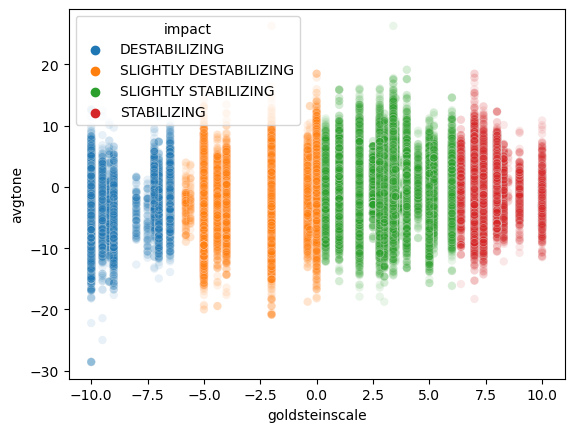

In [38]:
# Are high impact events reported with emotive tone?
# Surprisingly, no
_ = sns.scatterplot(data=df, x="goldsteinscale", y="avgtone", hue="impact", alpha=0.1)

In [39]:
# Deciles of nummentions
np.percentile(df["nummentions"], range(10, 101, 10))

array([  1.,   2.,   2.,   2.,   3.,   4.,   5.,   7.,  10., 190.])

In [40]:
# Scale
scaler = MinMaxScaler()
df["scaledgoldsteinscale"] = scaler.fit_transform(df["goldsteinscale"].values.reshape(-1,1))

## Based on avg tone

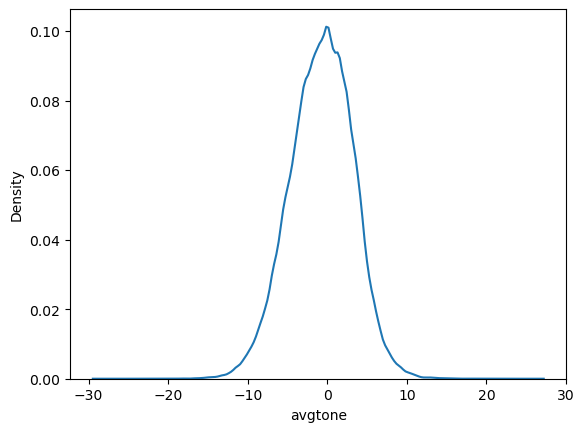

In [41]:
# Check distribution
# Approximately gaussian, centered at 0
_ = sns.kdeplot(df["avgtone"])

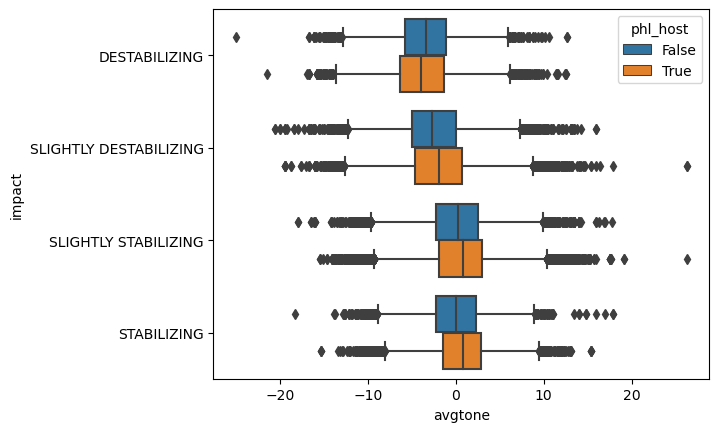

In [42]:
# Compare tone with goldstein scale by phl_host
subset = df[~df["generic_headline"]]
_ = sns.boxplot(data=subset, x="avgtone", y="impact", hue="phl_host", orient="h")

In [43]:
# Bin according to standard deviations from the mean
# Based on 68-95-99.7 rule
bins = sorted([-np.inf, np.inf] + [df["avgtone"].mean() + (i*df["avgtone"].std()) for i in range(-3,4)])
labels = [i for i in range(-4,5) if i!=0]
df["binned_avgtone"] = pd.cut(df["avgtone"], bins=bins, labels=labels)

In [44]:
# Sample headlines per bin
sample = lambda ser: ser.dropna().sample(5, random_state=123).values.tolist()
df.groupby(["binned_avgtone"])["headline"].apply(sample).to_dict()

{-4: ['BANTAG ZULUETA INDICTED 2 INMATES TORTURE',
  'CALOOCAN COP CONVICTED TORTURE PLANTING EVIDENCE CARL KULOT DRUG WAR CASES',
  'PHILIPPINE PRISONS CHIEF ACCUSED OF ORDERING JOURNALIST MURDER',
  'HATE CRIME CHARGES DROPPED AGAINST 220510398.HTML',
  'SANDIGAN JUNKS GRAFT MALVERSATION CASES AGAINST PAMPANGA TOWN MAYOR 5 OTHERS'],
 -3: ['HOUSE CITES LTFRB WHISTLEBLOWER TUMBADO IN CONTEMPT FOR INCONSISTENT ANSWERS',
  'AUSSIE CHILD SEX OFFENDER TO SPEND 129 YEARS IN JAIL',
  'COURT CLEARS 43 FARMERS 2016 CLASH COPS',
  'MANILA COURT DENIES HABEAS CORPUS PETITION DEGAMO SLAY SUSPECT',
  'GREEDY PHILIPPINES TRADERS BLAMED HOARDING FOOD JACKING PRICES THERES NO SHORTAGE'],
 -2: ['PHILIPPINES ABSTENTION IN UN VOTE NOT AGAINST ISRAEL HAMAS TRUCE DEPT OF FOREIGN AFFAIRS',
  'LTO PROBES SUSPECTS IN MANDALUYONG CITY MULTI VEHICLE COLLISION',
  'COP ARRESTED PALS SLAY',
  '2023 08 27 US MARINES KILLED IN OSPREY CRASH DURING TRAINING MISSION IN AUSTRALIA',
  'CARLO JORGE JOAN REYES SWORN IN N

## Based on actor

In [45]:
# Sparse features will be ignored
actor_cols = [c for c in df.columns if str(c).startswith("actor")]
describe_data(df[actor_cols])

,sparsity,unique,top,freq,pct
actor1geo_type,0.000000,6,4,259985,0.660986
actor2geo_type,0.000000,6,4,226258,0.575239
actor1code,0.063270,1205,PHL,200489,0.509723
actor1name,0.063270,1930,PHILIPPINE,183485,0.466492
actor1geo_fullname,0.076165,5809,"Philippine, Benguet, Philippines",58247,0.148087
actor2code,0.179453,1198,PHL,151243,0.38452
actor2name,0.179453,1954,PHILIPPINE,143214,0.364107
actor2geo_fullname,0.189694,5462,"Philippine, Benguet, Philippines",52301,0.13297
actor1countrycode,0.220685,191,PHL,236678,0.60173
actor2countrycode,0.351197,186,PHL,181454,0.461329


### Role codes

In [46]:
# Check how much can be matched
country_keys = list(country_code_map.keys())
role_keys = list(role_code_map.keys())
country_role_keys = list(country_role_code_map.keys())
gov_arm_keys = list(gov_arm_code_map.keys())
country_gov_arm_keys = list(country_gov_arm_code_map.keys())
known_keys =  country_keys + role_keys + country_role_keys + gov_arm_keys + country_gov_arm_keys

fxn = lambda ser: {"Sparsity": ser.isna().mean(), 
                   "Country Keys":ser.dropna().isin(country_keys).mean(), 
                   "Role Keys":ser.dropna().isin(role_keys).mean(), 
                   "Country Role Keys":ser.dropna().isin(country_role_keys).mean(), 
                   "Gov Arm Keys":ser.dropna().isin(gov_arm_keys).mean(), 
                   "Country Gov Arm Keys":ser.dropna().isin(country_gov_arm_keys).mean(), 
                   "Known Keys":ser.dropna().isin(known_keys).mean()}
pd.DataFrame.from_dict({code:fxn(df[code])for code in ["actor1code", "actor2code"]})

,actor1code,actor2code
Sparsity,0.063270,0.179453
Country Keys,0.696745,0.653816
Role Keys,0.147819,0.185245
Country Role Keys,0.114881,0.114886
Gov Arm Keys,0.004079,0.004604
Country Gov Arm Keys,0.005021,0.003923
Known Keys,0.968546,0.962475


In [47]:
# Map
df["actor1role"] = df["actor1code"].map({**country_code_map, **role_code_map, **country_role_code_map}).str.upper()
df["actor2role"] = df["actor2code"].map({**country_code_map, **role_code_map, **country_role_code_map}).str.upper()

In [48]:
# Map interaction between actors
map_ = {
    **{k:"COUNTRY" for k in country_keys}, 
    **{k:"ROLE" for k in role_keys}, 
    **{k:"COUNTRY ROLE" for k in country_role_keys}, 
    **{k:"GOV ARM" for k in gov_arm_keys}, 
    **{k:"COUNTRY GOV ARM" for k in country_gov_arm_keys}
}
df["actor1rolegroup"] = df["actor1code"].map(map_).fillna("UNKNOWN")
df["actor2rolegroup"] = df["actor2code"].map(map_).fillna("UNKNOWN")
df["actorroleinteraction"] = df["actor1rolegroup"] + "-" + df["actor2rolegroup"]
df["actorequivalentroles"] = df["actor1rolegroup"] == df["actor2rolegroup"]

df["actorroleinteraction"].value_counts(normalize=True).head()
df["actorequivalentroles"].value_counts(normalize=True).head()

actorroleinteraction
COUNTRY-COUNTRY    0.268094
COUNTRY-UNKNOWN    0.185377
COUNTRY-ROLE       0.134829
ROLE-COUNTRY       0.122228
UNKNOWN-COUNTRY    0.082554
Name: proportion, dtype: float64

actorequivalentroles
False    0.71981
True     0.28019
Name: proportion, dtype: float64

In [85]:
# Most common role group (actors 1 and 2 combined)?
vc_kwargs = {"dropna":False, "normalize":True}
df["actor1rolegroup"].value_counts(vc_kwargs).add(df["actor2rolegroup"].value_counts(vc_kwargs)).sort_values(ascending=False).div(2)

COUNTRY            0.594575
UNKNOWN            0.151489
ROLE               0.145235
COUNTRY ROLE       0.100941
COUNTRY GOV ARM    0.003961
GOV ARM            0.003800
Name: proportion, dtype: float64

In [68]:
# Most common values for each role group (actors 1 and 2 combined)?
for rolegroup in df["actor1rolegroup"].unique().tolist():
    print(rolegroup)
    df[df["actor1rolegroup"]==rolegroup]["actor1code"].value_counts().add(
        df[df["actor2rolegroup"]==rolegroup]["actor2code"].value_counts()
        ).sort_values(ascending=False)[:3].astype(int)

COUNTRY


PHL    351732
CHN     31408
USA     21497
Name: count, dtype: int64

UNKNOWN


TWN          2073
IGOSEAASN    1513
REL          1150
Name: count, dtype: int64

COUNTRY ROLE


PHLGOV    25824
PHLMIL    10843
PHLCOP     5900
Name: count, dtype: int64

ROLE


GOV    35352
MIL    13037
BUS    10622
Name: count, dtype: int64

COUNTRY GOV ARM


PHLGOVMIL    923
PHLGOVBUS    411
PHLGOVJUD    270
Name: count, dtype: int64

GOV ARM


GOVMIL    1119
GOVEDU     535
GOVAGR     386
Name: count, dtype: int64

## Based on time

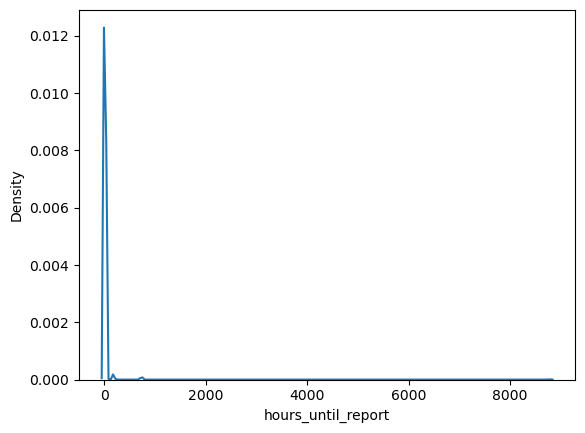

In [86]:
df["hours_until_report"] = (pd.to_datetime(df["dateadded"].astype(str), format='%Y%m%d%H%M%S') - pd.to_datetime(df["eventdate"].astype(str), format='%Y%m%d')).dt.total_seconds()/(60*60)
_ = sns.kdeplot(df["hours_until_report"])

Highly skewed.

# Feature and sample selection

In [87]:
# Backup full df
full_df = df.copy()
full_df.shape

(393329, 43)

In [88]:
# Feature selection
features = [
    "hours_until_report",  # Timeliness
    "avgtone", # Negativity
    "nummentions",  # Continuity
    "actorroleinteraction", "actorequivalentroles",  # Conflict
    "eventrootdescription", "scaledgoldsteinscale",  # Impact
    "phl_host",  # Proximity
]
descriptors = ["headline", "actor1name", "actor1code", "actor2name", "actor2code"]
df = df[features + descriptors]
df.shape

(393329, 13)

In [89]:
# Sample selection
df = df[~(no_event_code | full_df["generic_headline"] | flight_mask)]
df.shape

(240729, 13)

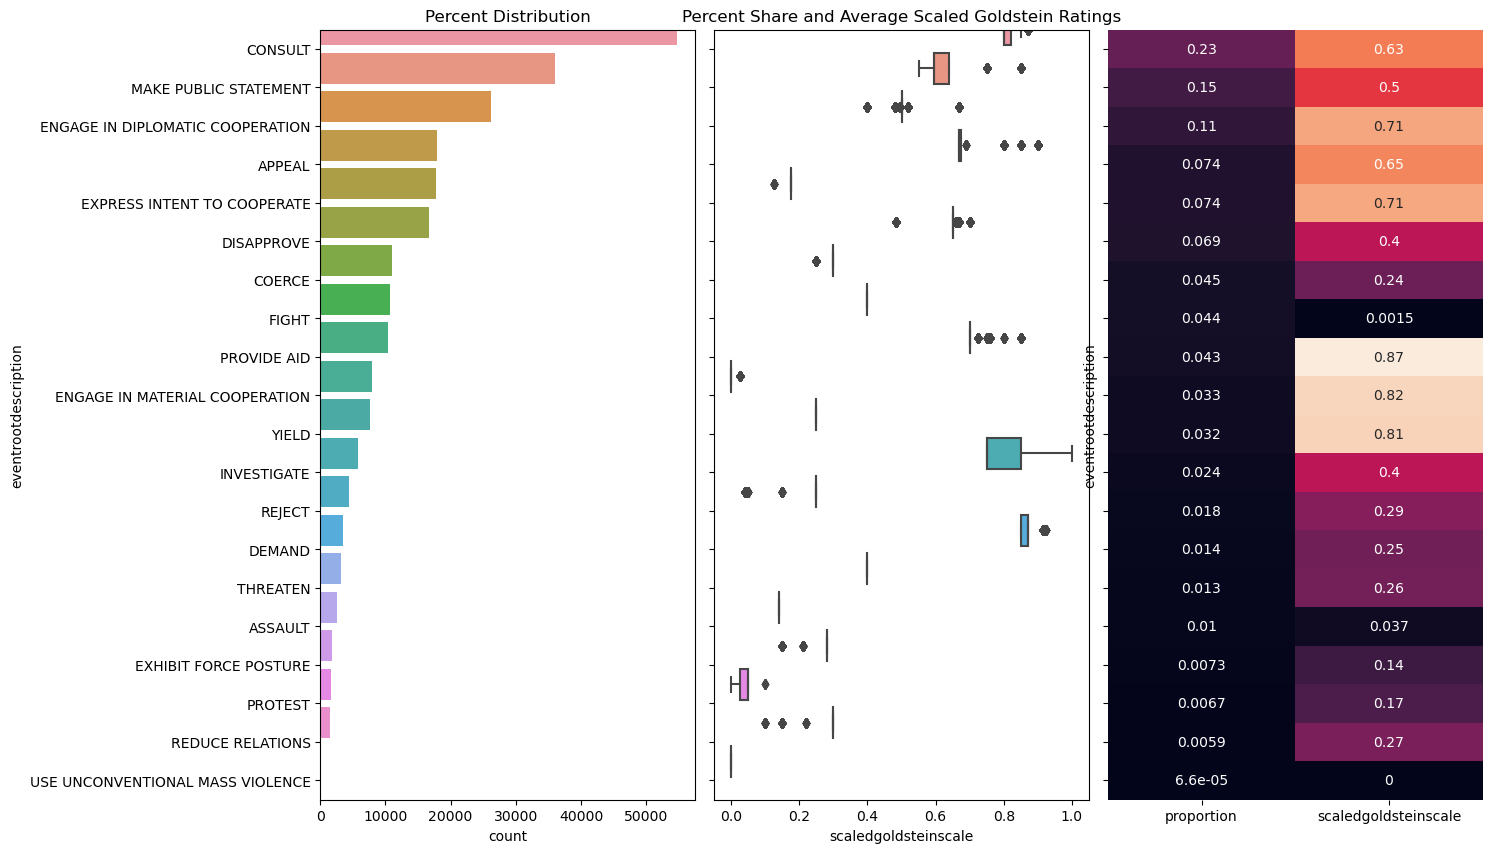

In [90]:
# Look into disrtribution of events
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15,10))
_ = fig.subplots_adjust(wspace=0.05)
_ = sns.barplot(y=df["eventrootdescription"].value_counts().index, x=df["eventrootdescription"].value_counts(), ax=axes[0])
_ = axes[0].set_title("Percent Distribution")
_ = sns.boxplot(df, y="eventrootdescription", x="scaledgoldsteinscale", ax=axes[1])
_ = axes[1].set_title("Range of Scaled Goldstein Ratings")
_ = axes[1].set_ylabel("")
_ = sns.heatmap(pd.DataFrame([
    df["eventrootdescription"].value_counts(normalize=True), 
    df.groupby("eventrootdescription")["scaledgoldsteinscale"].mean()
]).T, cbar=False, annot=True, ax=axes[2])
_ = axes[1].set_title("Percent Share and Average Scaled Goldstein Ratings")

In [91]:
# Retain rows by bottom 20% and top 20% in df["scaledgoldsteinscale"]
# Reasoning: Represent both stabilizing and destabilizing events
llim, ulim = np.quantile(df["scaledgoldsteinscale"], [1/5, 1-1/5])
print(f"{llim=}, {ulim=}")
df = df[(df["scaledgoldsteinscale"]<=llim) | (df["scaledgoldsteinscale"]>=ulim)]
df.shape

llim=0.4, ulim=0.7


(118372, 13)

In [92]:
# Preview
df.head(10)

,hours_until_report,avgtone,nummentions,actorroleinteraction,actorequivalentroles,eventrootdescription,scaledgoldsteinscale,phl_host,headline,actor1name,actor1code,actor2name,actor2code
globaleventid,,,,,,,,,,,,,
1084635672,8.25,-1.671309,4,COUNTRY-COUNTRY,True,ENGAGE IN MATERIAL COOPERATION,0.820,False,INDIA AIMS TO TRIPLE DEFENCE EXPORTS TO 5B BY ...,HINDUSTAN,IND,PHILIPPINE,PHL
1084635914,8.25,-1.671309,4,COUNTRY-COUNTRY,True,ENGAGE IN MATERIAL COOPERATION,0.820,False,INDIA AIMS TO TRIPLE DEFENCE EXPORTS TO 5B BY ...,PAKISTAN,PAK,PHILIPPINE,PHL
1084742924,22.50,-1.990050,2,COUNTRY-COUNTRY,True,PROTEST,0.175,True,PH INTRUDED INTO CHINESE WATERS BEIJING CLAIMS,PHILIPPINE,PHL,CHINA,CHN
1084637094,8.50,5.610098,10,COUNTRY-UNKNOWN,False,ENGAGE IN DIPLOMATIC COOPERATION,0.900,True,KNAUF DSWD FIELD OFFICE IV A INK PARTNERSHIP T...,CALABARZON,PHL,NaN,NaN
1084638965,8.50,-0.689655,10,COUNTRY-UNKNOWN,False,REJECT,0.300,False,OGGETTI STATI UNITI CANADA,PHILIPPINE,PHL,NaN,NaN
1084628218,6.50,-1.552795,6,COUNTRY-UNKNOWN,False,DISAPPROVE,0.400,False,FILIPINAS ACUSA A CHINA DE USAR LUZ L%C3%A1SER...,PHILIPPINE,PHL,NaN,NaN
1084660190,12.00,1.703163,4,COUNTRY ROLE-ROLE,False,REJECT,0.300,True,PBBM CHARTER CHANGE NOT A PRIORITY,MANILA,PHLGOV,ADMINISTRATION,GOV
1084727028,20.25,0.590551,10,COUNTRY-UNKNOWN,False,EXPRESS INTENT TO COOPERATE,0.760,True,DOTR TO AWARD REMAINING SUBWAY CONTRACTS BY Q3,MANILA,PHL,NaN,NaN
1084632852,7.50,-2.777778,10,COUNTRY-COUNTRY,True,DISAPPROVE,0.400,False,FILIPPINERNA KINA ANVANDE MILITAR LASER,CHINESE,CHN,FILIPINO,PHL


# EDA

In [57]:
# Describe non-numeric feature columns
describe_data(df[features].select_dtypes(["O", bool]))

,sparsity,unique,top,freq,pct
actorroleinteraction,0.0,31,COUNTRY-UNKNOWN,26944,0.227621
actorequivalentroles,0.0,2,False,91534,0.773274
eventrootdescription,0.0,20,EXPRESS INTENT TO COOPERATE,17701,0.149537
phl_host,0.0,2,True,77222,0.652367


In [58]:
# Describe numeric feature columns
describe_data(df[features].select_dtypes(np.number))

,sparsity,mean,std,min,25%,50%,75%,max
hours_until_report,0.0,24.947177,259.013679,0.0,7.250000,12.250000,17.500000,8783.500000
avgtone,0.0,-1.544439,4.145955,-25.0,-4.365978,-1.460674,1.391863,26.296296
nummentions,0.0,4.725045,3.928508,1.0,2.000000,4.000000,7.000000,190.000000
scaledgoldsteinscale,0.0,0.507478,0.299067,0.0,0.250000,0.400000,0.800000,1.000000


In [59]:
# Describe non-headline descriptor columns
describe_data(df[descriptors[1:]])
tmp = pd.DataFrame([df[descriptors[1:]].value_counts(), df[descriptors[1:]].value_counts(normalize=True)]).T
tmp.head(20) # Top 20 insteractios

,sparsity,unique,top,freq,pct
actor1name,0.069839,1377,PHILIPPINE,55737,0.470863
actor1code,0.069839,752,PHL,63524,0.536647
actor2name,0.227233,1376,PHILIPPINE,39813,0.336338
actor2code,0.227233,768,PHL,42945,0.362797


count  proportion
actor1name    actor1code actor2name    actor2code                    
PHILIPPINE    PHL        CHINA         CHN         2831.0    0.034024
CHINA         CHN        PHILIPPINE    PHL         2022.0    0.024301
PHILIPPINE    PHL        GOVERNMENT    GOV         1110.0    0.013340
UNITED STATES USA        PHILIPPINE    PHL          891.0    0.010708
PRESIDENT     GOV        PHILIPPINE    PHL          888.0    0.010672
PHILIPPINE    PHL        UNITED STATES USA          804.0    0.009663
POLICE        COP        PHILIPPINE    PHL          786.0    0.009446
PHILIPPINE    PHL        CHINESE       CHN          749.0    0.009002
                         PRESIDENT     GOV          702.0    0.008437
GOVERNMENT    GOV        PHILIPPINE    PHL          674.0    0.008100
PHILIPPINE    PHLGOV     PHILIPPINE    PHL          657.0    0.007896
              PHL        PHILIPPINE    PHLGOV       652.0    0.007836
                         MILITARY      MIL          601.0    0.007223
CHINESE       CHN        PHILIPPINE    PHL          566.0    0.006802
PHILIPPINE    PHL        POLICE        COP          531.0    0.006382
                         PHILIPPINE    PHLMIL       526.0    0.006322
                                       PHLCOP       490.0    0.005889
MILITARY      MIL        PHILIPPINE    PHL          477.0    0.005733
VIETNAM       VNM        PHILIPPINE    PHL          474.0    0.005697
PHILIPPINE    PHL        JAPAN         JPN          440.0    0.005288

/Users/user/miniforge3/envs/quick/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


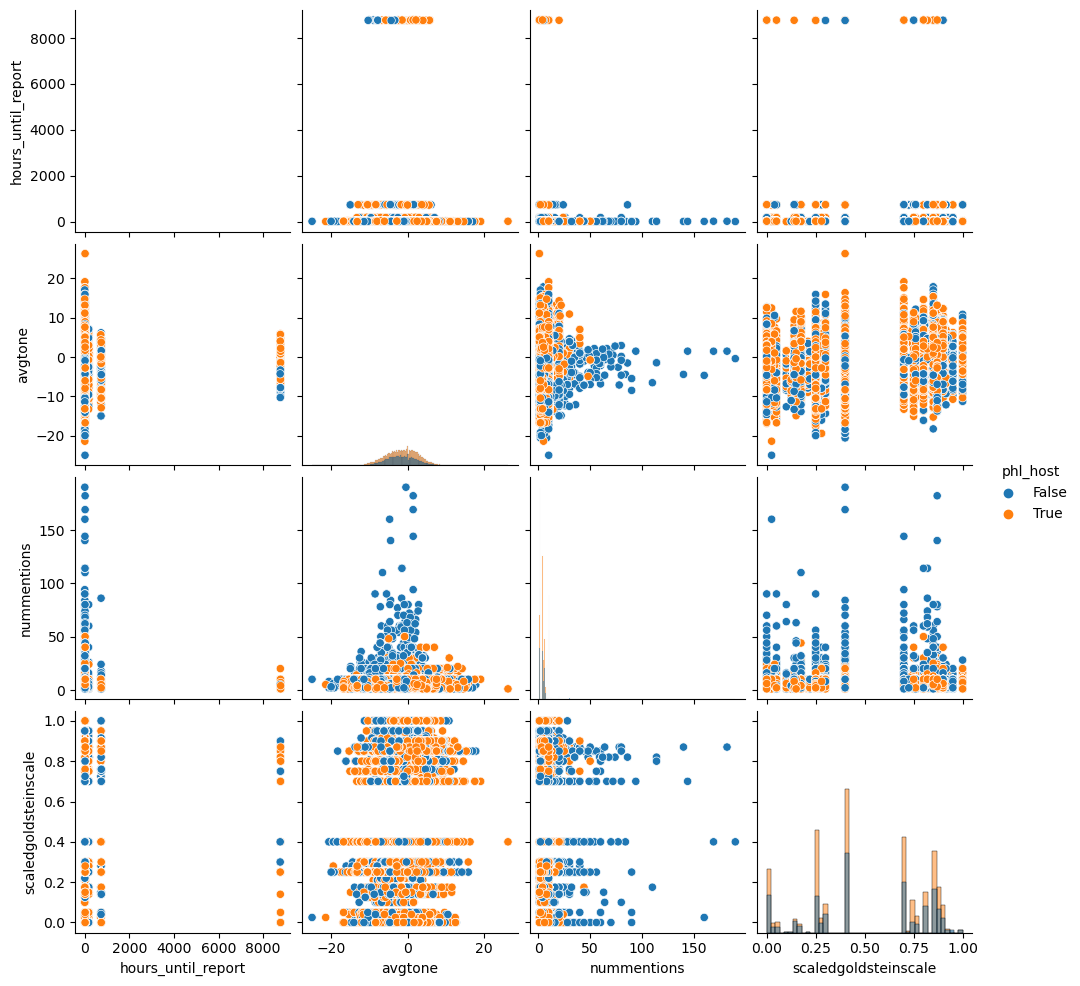

In [60]:
# Plot numerical features against each other with phl_host as slicer
slicer = "phl_host"
data = df.select_dtypes(np.number).merge(df[[slicer]], left_index=True, right_index=True)
_ = sns.pairplot(data, hue=slicer, diag_kind="hist")

/Users/user/miniforge3/envs/quick/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


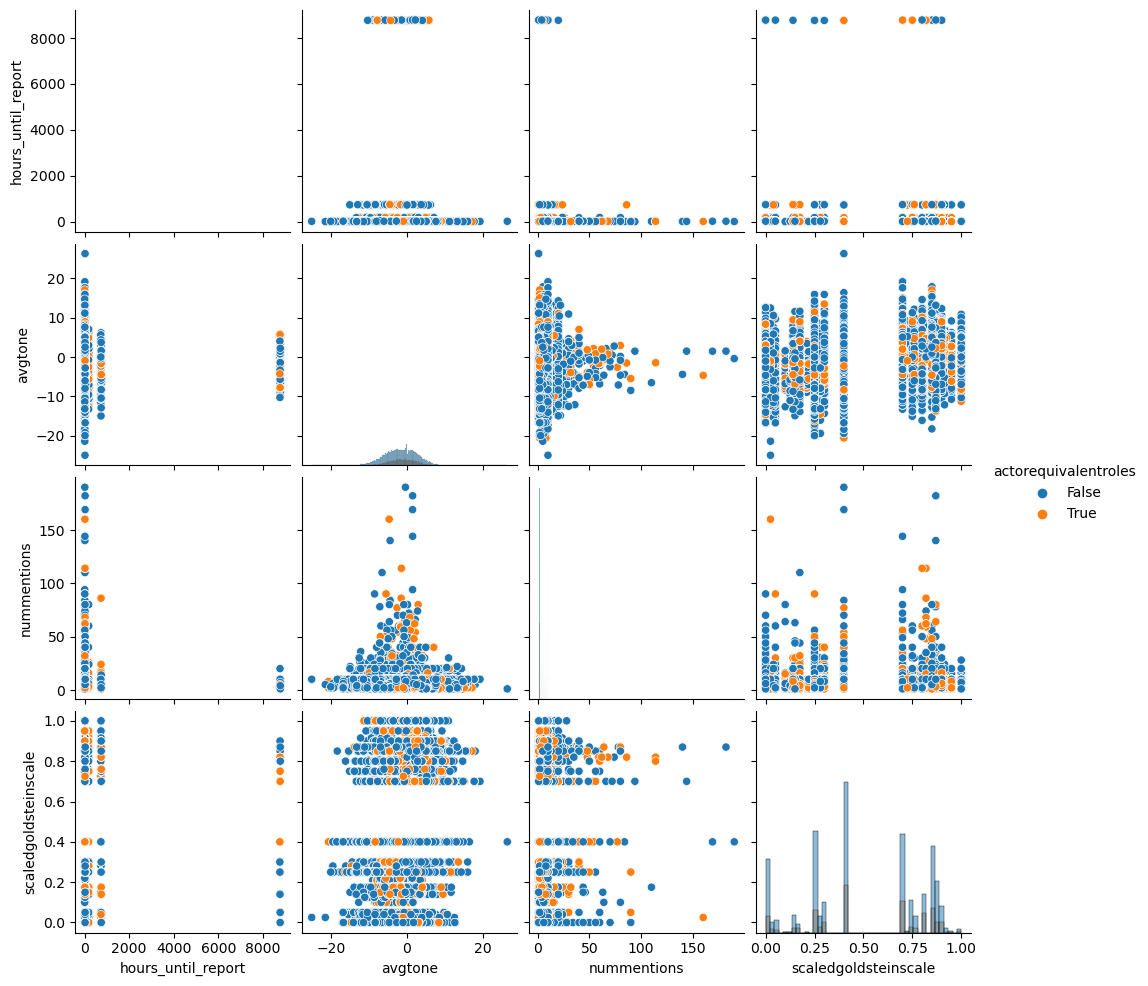

In [61]:
# Plot numerical features against each other with actorequivalentroles as slicer
slicer = "actorequivalentroles"
data = df.select_dtypes(np.number).merge(df[[slicer]], left_index=True, right_index=True)
_ = sns.pairplot(data, hue=slicer, diag_kind="hist")

# Vectorization

## Boolean features

In [62]:
# Convert to int
bool_vectors = df.select_dtypes(bool).astype(int)

## Categorical features

In [63]:
# Vectorize actorroleinteraction and eventrootdescription into 50 vectors
from prince import MCA
mca = MCA(random_state=19, n_components=40)
cat_vectors = mca.fit_transform(df[features].select_dtypes("O"))
cat_vectors.columns = cat_vectors.columns.map(lambda x: f"mca{x}")

In [64]:
# Check cumulative variance
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.589,2.40%,2.40%
1,0.568,2.32%,4.72%
2,0.543,2.22%,6.94%
3,0.527,2.15%,9.09%
4,0.524,2.14%,11.23%
5,0.521,2.13%,13.35%
6,0.518,2.11%,15.46%
7,0.515,2.10%,17.56%
8,0.513,2.09%,19.66%


<Axes: >

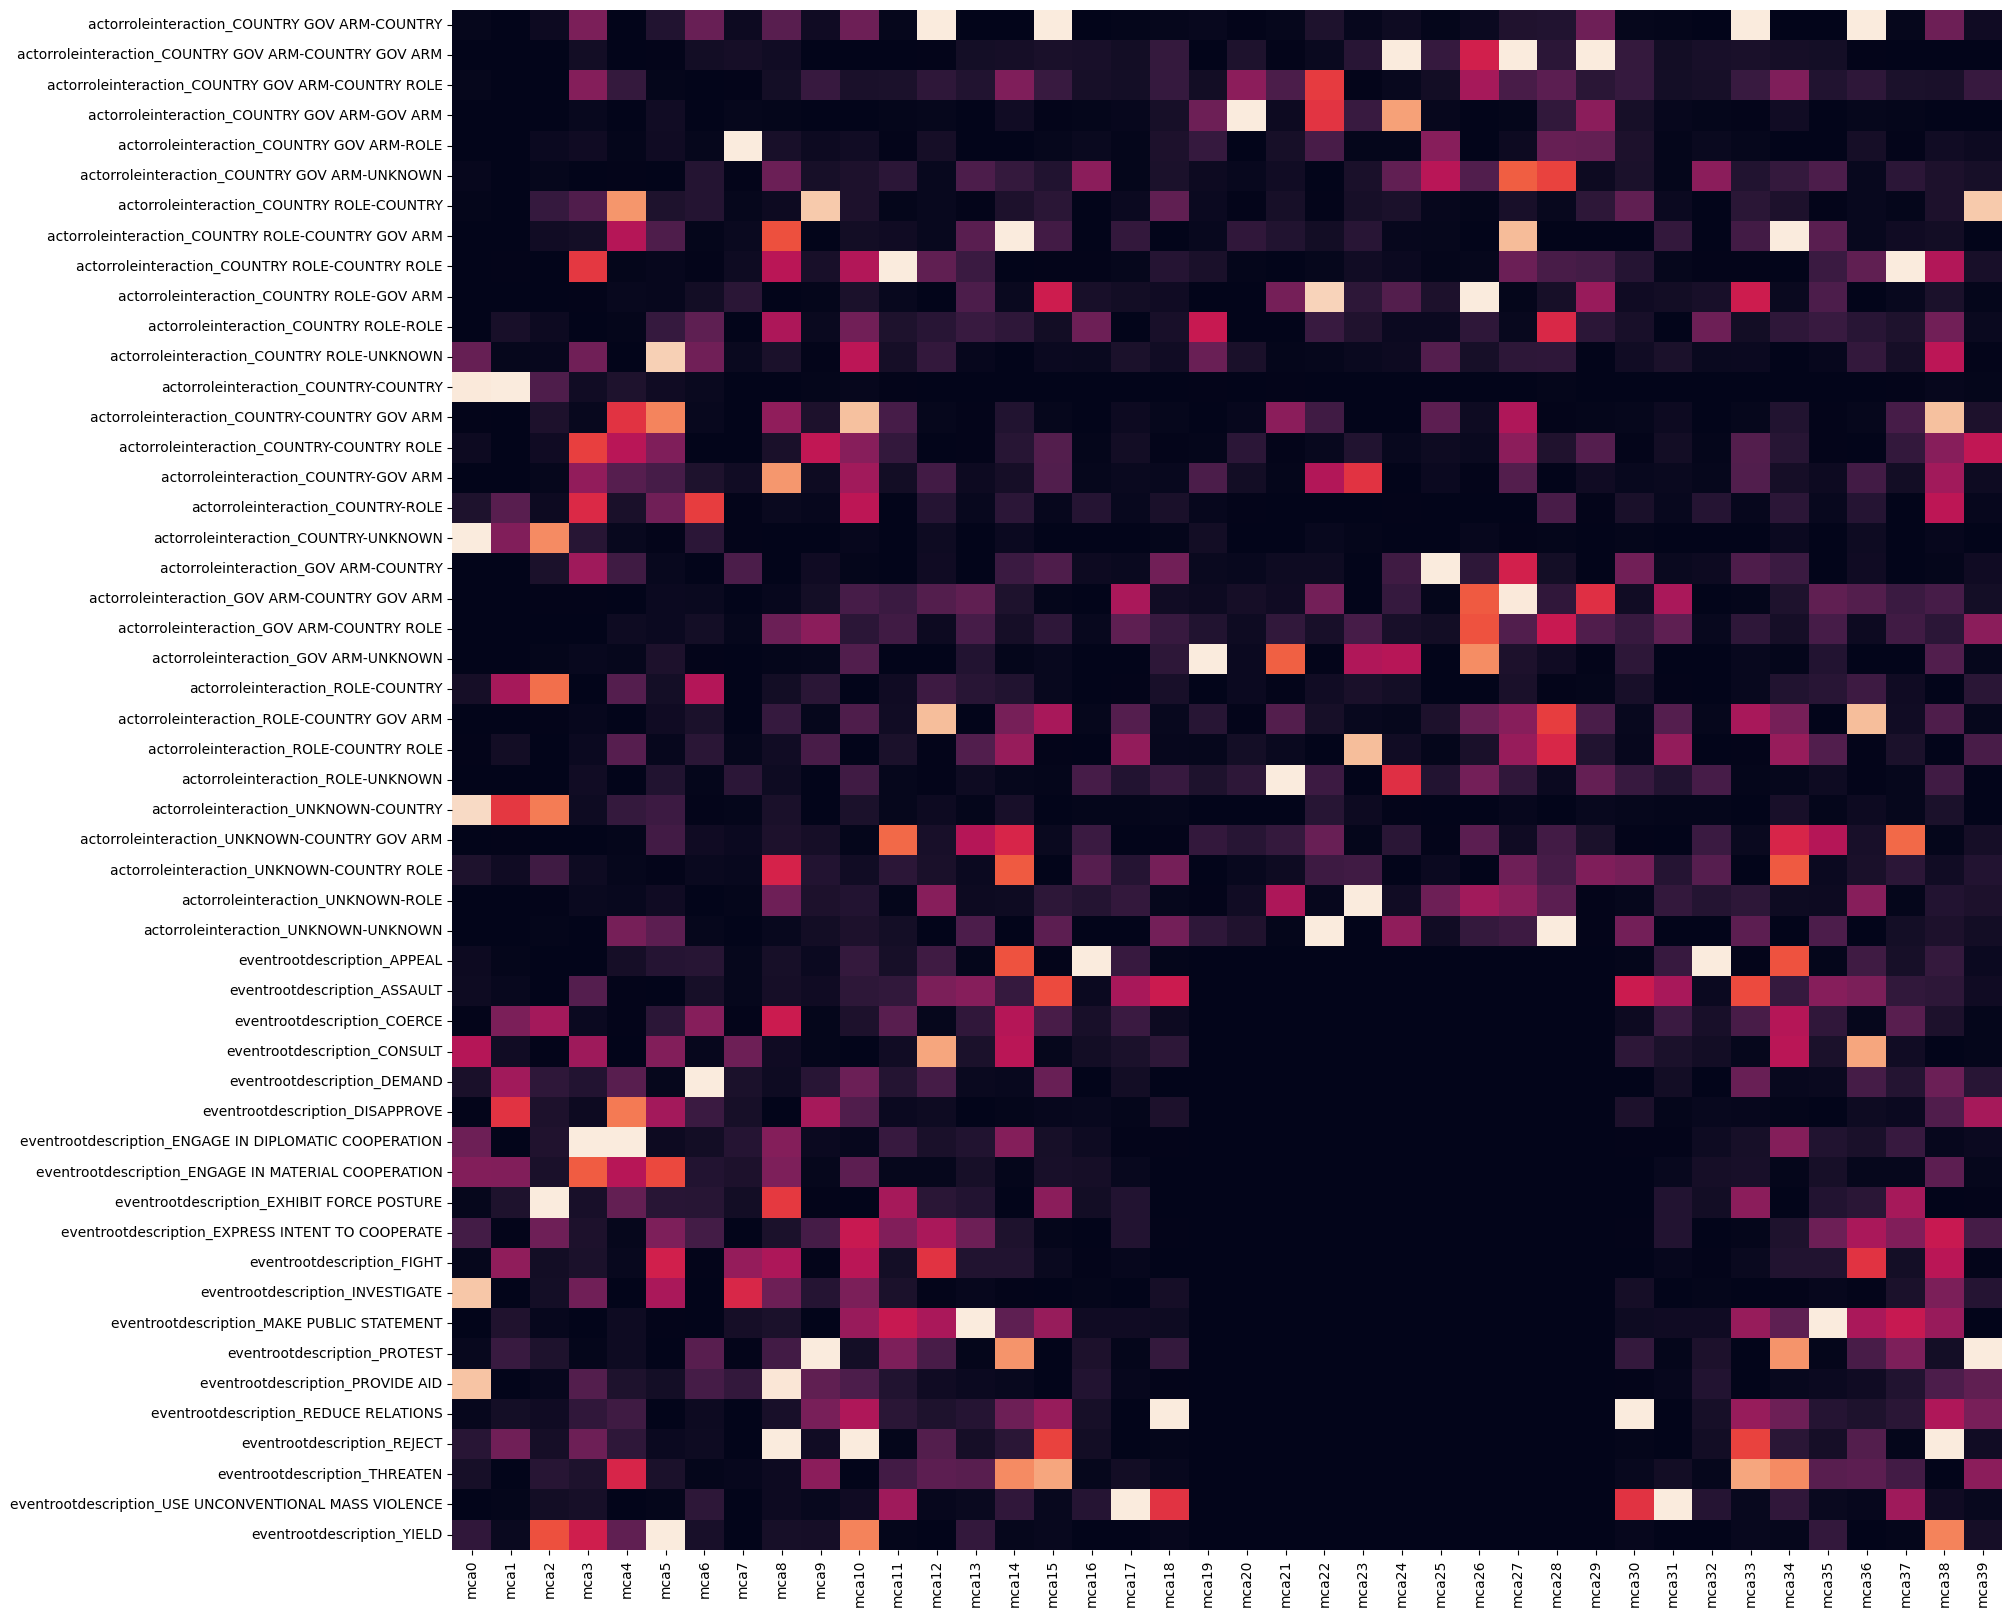

In [66]:
# Check contributions
contributions = mca.column_contributions_
contributions.columns = contributions.columns.map(lambda x: f"mca{x}")

scaled_contributions = pd.DataFrame(MinMaxScaler().fit_transform(contributions), columns=contributions.columns.copy(), index=contributions.index.copy())
fig, axes = plt.subplots(figsize=(20,20))
sns.heatmap(scaled_contributions, cbar=False, ax=axes)

In [72]:
# Export as parquet
contributions.to_parquet("../results/loadings/mca_loadings.parquet")

In [66]:
# Combine in single matrix
matrix = df.select_dtypes(np.number).merge(bool_vectors, left_index=True, right_index=True).merge(cat_vectors, left_index=True, right_index=True)
matrix.shape
matrix.head(10)

(118372, 46)

,hours_until_report,avgtone,nummentions,scaledgoldsteinscale,actorequivalentroles,phl_host,mca0,mca1,mca2,mca3,...,mca30,mca31,mca32,mca33,mca34,mca35,mca36,mca37,mca38,mca39
globaleventid,,,,,,,,,,,,,,,,,,,,,
1084635672,8.25,-1.671309,4,0.820,1,0,-1.157517,-1.313079,-0.560937,0.879300,...,-0.040340,0.212308,0.323477,0.247677,0.052445,0.316026,-0.111070,-0.185160,-0.350988,-0.199873
1084635914,8.25,-1.671309,4,0.820,1,0,-1.157517,-1.313079,-0.560937,0.879300,...,-0.040340,0.212308,0.323477,0.247677,0.052445,0.316026,-0.111070,-0.185160,-0.350988,-0.199873
1084742924,22.50,-1.990050,2,0.175,1,1,-0.900608,-1.643740,-0.953467,-0.095355,...,-0.950376,-0.282317,-0.909765,0.040111,1.742591,-0.253546,-0.937116,1.293114,0.503294,-2.546213
1084637094,8.50,5.610098,10,0.900,0,1,-0.135287,-0.363032,0.917751,-1.043078,...,-0.038089,-0.170249,0.345272,-0.331069,-0.585227,0.432230,-0.220517,0.554827,-0.203176,-0.256597
1084638965,8.50,-0.689655,10,0.300,0,0,1.002015,-1.193705,0.860600,0.826830,...,0.221744,-0.069497,-0.431648,1.001403,-0.320772,0.355014,0.707719,-0.129421,1.068818,0.313594
1084628218,6.50,-1.552795,6,0.400,0,0,0.498465,-0.969562,0.304619,0.045464,...,-0.157087,0.044420,-0.150607,-0.111133,0.022499,-0.035537,-0.024693,0.162702,-0.330091,0.492486
1084660190,12.00,1.703163,4,0.300,0,1,0.496634,-0.243749,-0.052751,0.580513,...,0.752099,0.054609,-1.954680,1.456998,0.226767,1.252720,1.237292,0.454498,2.041318,0.669459
1084727028,20.25,0.590551,10,0.760,0,1,0.265435,-0.293202,0.902380,-0.008585,...,0.125748,-0.302717,-0.009477,-0.080996,0.251754,-0.417425,-0.319481,-0.384227,0.335956,0.314251
1084632852,7.50,-2.777778,10,0.400,1,0,-0.622667,-1.254368,-0.482706,-0.006319,...,-0.189190,0.096701,-0.170993,-0.094742,-0.088566,-0.000988,-0.123786,0.079700,-0.202070,0.435551


In [ ]:
# Export
matrix.to_parquet("../matrices/matrix.parquet")

## Scaling

In [67]:
# Check for skew
matrix.skew().describe()

count    46.000000
mean      6.243788
std      13.146398
min      -2.631730
25%      -0.069002
50%       1.400758
75%       5.133977
max      61.399384
dtype: float64

In [68]:
# Isolate skewed cols
skewed_cols = matrix.skew()[matrix.skew().abs()>3].index.tolist()
skewed_cols

['hours_until_report',
 'nummentions',
 'mca7',
 'mca13',
 'mca18',
 'mca19',
 'mca20',
 'mca21',
 'mca23',
 'mca24',
 'mca25',
 'mca26',
 'mca27',
 'mca29',
 'mca31']

In [69]:
# Unskew series
from lib.utils.outlier_handlers import acceptable_range, unskew_series

scaled_matrix = pd.DataFrame(index=df.index.copy())
for skewed_col in skewed_cols:
    unskewed_col, _ = unskew_series(matrix["hours_until_report"])
    scaled_matrix[skewed_col] = unskewed_col.values

In [70]:
# Combine skewed and unskewed features
scaled_matrix = scaled_matrix.merge(matrix[[c for c in matrix.columns if c not in skewed_cols]], left_index=True, right_index=True)[matrix.columns]

In [71]:
# Scale to a range of [0,1]
scaled_matrix = pd.DataFrame(MinMaxScaler().fit_transform(scaled_matrix), columns=matrix.columns.copy(), index=matrix.index.copy())

In [ ]:
# Export
scaled_matrix.to_parquet("../matrices/scaled_matrix.parquet")

# Unsupervised Learning

## Feasibility check

In [72]:
from sklearn.decomposition import PCA

0.597325936475251

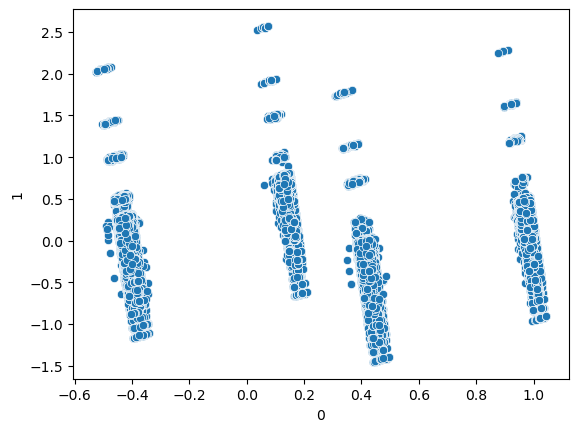

In [73]:
# At n_components=2
pca = PCA(random_state=19, n_components=2)
_ = pca.fit(scaled_matrix)
pca.explained_variance_ratio_.sum()
pca_2 = pd.DataFrame(pca.transform(scaled_matrix))
_ = sns.scatterplot(pca_2, x=0, y=1)

0.8098726371114896

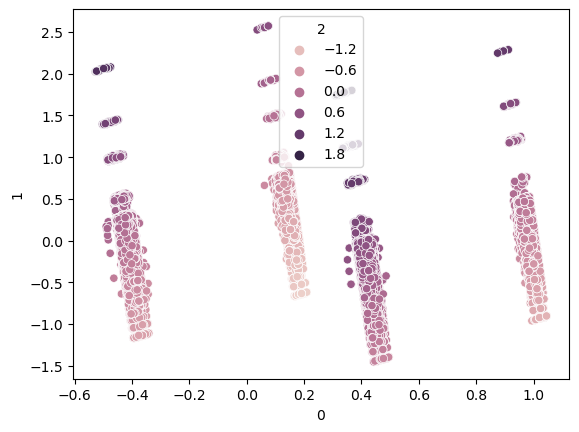

In [74]:
# At n_components=3
pca = PCA(random_state=19, n_components=3)
_ = pca.fit(scaled_matrix)
pca.explained_variance_ratio_.sum()
pca_3 = pd.DataFrame(pca.transform(scaled_matrix))
_ = sns.scatterplot(pca_3, x=0, y=1, hue=2)

In [75]:
# Approximate sizes of clusters
visual_cluster_sizes = [
    ((pca_2[0]<-0.3) & (pca_2[1]>0.8)).sum() / 3,
    ((pca_2[0]>0) & (pca_2[0]<0.3) & (pca_2[1]>0.85)).sum() / 4,
    ((pca_2[0]>0.2) & (pca_2[0]<0.55) & (pca_2[1]>0.5)).sum() / 3,
    ((pca_2[0]>0.8) & (pca_2[1]>0.8)).sum() / 3,
]
visual_cluster_sizes

[243.0, 70.0, 145.66666666666666, 133.33333333333334]

In [76]:
# Check for ave pairwise distances
from sklearn.metrics import pairwise_distances
avg_dists = np.mean(pairwise_distances(scaled_matrix.sample(1000, random_state=19)))
avg_dists

1.1000274905463787

## Baseline Modeling

In [77]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score

In [78]:
# Set baseline params based on EDA
diffs_from_geometric_sequence = [abs((2**i)-min(visual_cluster_sizes)) for i in range(0,11)]
min_samples = 2 ** diffs_from_geometric_sequence.index(min(diffs_from_geometric_sequence))

eps = np.round(avg_dists * 0.1, 4)

min_samples=64, eps=0.11: baseline_score=1.8855
CPU times: user 1min 10s, sys: 524 ms, total: 1min 11s
Wall time: 10.6 s


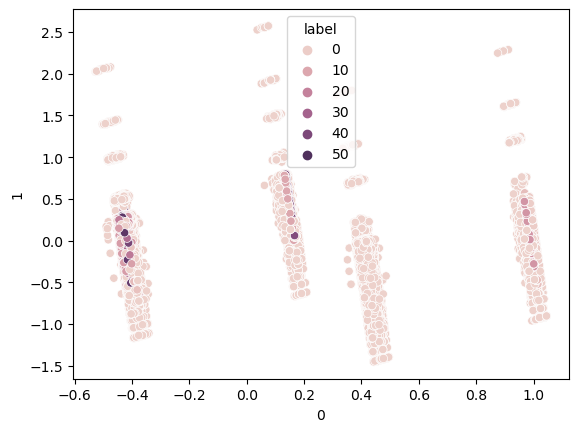

In [79]:
%%time
baseline_dbscan = DBSCAN(min_samples=min_samples, eps=eps).fit(scaled_matrix)
baseline_score = np.round(davies_bouldin_score(np.asarray(scaled_matrix), baseline_dbscan.labels_), 4)
print(f"{min_samples=}, {eps=}: {baseline_score=}")

pca_2["label"] = baseline_dbscan.labels_
top_20 = pca_2[pca_2["label"].isin(pca_2["label"].value_counts()[:20].index.tolist())]
_ = sns.scatterplot(top_20, x=0, y=1, hue="label")

## Parameter Tuning 

In [80]:
import joblib 
def generate_training_key(min_samples, eps):
    return f"{min_samples=}, {eps=}"

def dump_model(model, key, path="../models/"):
    joblib.dump(model, f'{path}{key}.joblib')

def train_dbscan(input_matrix, min_samples, eps):
    key = generate_training_key(min_samples, eps)
    score = np.nan

    model = DBSCAN(min_samples=min_samples, eps=eps).fit(input_matrix)
    labels = pd.Series(model.labels_, index=input_matrix.index.copy())

    # Only score if multiple clusters detected
    if labels.nunique()>1:
        score = np.round(davies_bouldin_score(np.asarray(input_matrix), np.array(labels)), 4)
    return key, model, labels, score

In [81]:
# Set up dataframe for labels and dict for scores
labels_df = pd.DataFrame(index=matrix.index.copy())
scores = {}

baseline_key = generate_training_key(min_samples=min_samples, eps=eps)
labels_df[baseline_key] = baseline_dbscan.labels_
scores[baseline_key] = baseline_score

In [82]:
# Define search grid
min_samples_values = [i for i in range(100, 1025, 25)]
eps_values = [i/100 for i in range(1, 30, 2)]

len(min_samples_values) * len(eps_values) # Unique combinations

grid_key = f"min_samples_{min(min_samples_values)}_{max(min_samples_values)}_eps_{min(eps_values)}_{max(eps_values)}"

555

In [83]:
%%time
# Train dbscan at different settings
for min_samples in min_samples_values:
    for eps in eps_values:
        key, model, labels, score = train_dbscan(scaled_matrix, min_samples, eps)
        labels_df[key] = labels
        scores[key] = score
        # Dump model if if performed well relatively to others
        valid_scores = [s for s in list(scores.values()) if not pd.isna(s)]
        if len(valid_scores) < 10:
            dump_model(model, key)
        elif score <= sorted(valid_scores)[9]:
            dump_model(model, key)

<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

CPU times: user 13h 1min 54s, sys: 12min 3s, total: 13h 13min 58s
Wall time: 11h 23min 45s


<timed exec>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [170]:
# Check results
eval_df = pd.DataFrame.from_dict({"scores":scores}, orient="index").T
eval_df["k"] = labels_df.nunique()
eval_df = eval_df.reset_index()

eval_df = eval_df.merge(eval_df["index"].str.extract(r'min_samples=(\d+), eps=(\d+\.\d+)'), left_index=True, right_index=True)

eval_df = eval_df.rename(columns={0:"min_samples", 1:"eps", "scores":"dbi", "index":"key"})[["key", "min_samples", "eps", "k", "dbi"]]
eval_df["min_samples"] = eval_df["min_samples"].astype(int) ; eval_df["eps"] = eval_df["eps"].astype(float)
eval_df = eval_df.dropna()
eval_df.sort_values("dbi").head(10)  # Top 10 settings

# Export
eval_df.to_csv(f"../results/{grid_key}.csv", index=False)

,key,min_samples,eps,k,dbi
2,"min_samples=100, eps=0.03",100,0.03,8.0,1.2117
33,"min_samples=150, eps=0.05",150,0.05,23.0,1.2650
3,"min_samples=100, eps=0.05",100,0.05,33.0,1.2960
18,"min_samples=125, eps=0.05",125,0.05,29.0,1.2987
170,"min_samples=375, eps=0.09",375,0.09,15.0,1.3077
94,"min_samples=250, eps=0.07",250,0.07,21.0,1.3081
155,"min_samples=350, eps=0.09",350,0.09,17.0,1.3093
78,"min_samples=225, eps=0.05",225,0.05,6.0,1.3134
108,"min_samples=275, eps=0.05",275,0.05,4.0,1.3182
80,"min_samples=225, eps=0.09",225,0.09,27.0,1.3235


In [150]:
# Exclude non-meaningful results-- only -1s
labels_df = labels_df[labels_df.nunique()[labels_df.nunique()>1].index]  

In [153]:
%%time
# Prepare scorer
from functools import partial
from sklearn.metrics import silhouette_score
partial_silhouette_scorer = partial(silhouette_score, X=scaled_matrix)
vectorized_partial_silhouette_scorer = lambda labels: partial_silhouette_scorer(labels=labels)

# Add silhouette score for top 50 settings
top_50_settings = eval_df.sort_values("dbi").head(50).apply(lambda row: f"min_samples={int(row.min_samples)}, eps={row.eps}", axis=1).values.tolist()
top_50_settings_silhoutte = labels_df[top_50_settings].agg(vectorized_partial_silhouette_scorer)
eval_df = eval_df.merge(pd.DataFrame(top_50_settings_silhoutte), left_on="key", right_index=True, how="left").rename(columns={0:"silhouette_score"})

CPU times: user 2h 8min 19s, sys: 38min 3s, total: 2h 46min 23s
Wall time: 3h 22min 13s


/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2737463210.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2737463210.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2737463210.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2737463210.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2737463210.py:9: Us

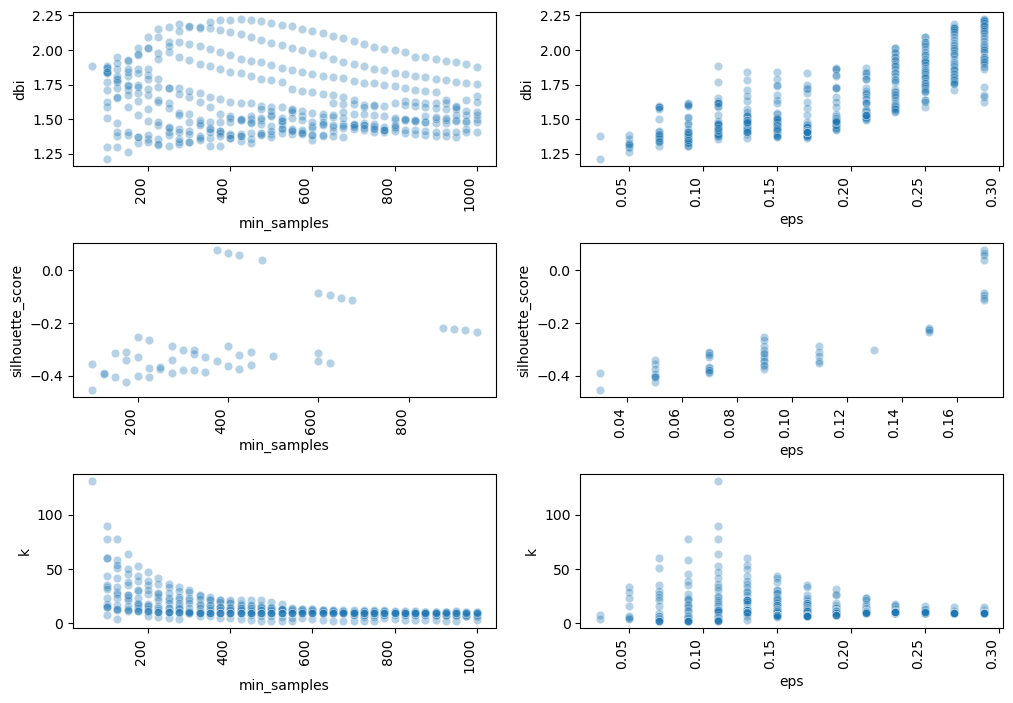

In [227]:
# Relation of settings to scores and k
# Ideal settings, bigger min_samples, smaller eps-- consistent with metric formulation
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8))
_ = fig.subplots_adjust(hspace=0.5)
for i, param in enumerate(["min_samples", "eps"]):
    for j, metric in enumerate(["dbi", "silhouette_score", "k"]):
        ax = axes[j, i]
        _ = sns.scatterplot(eval_df, y=metric, x=param, alpha=1/3, ax=ax)
        _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
_ = fig.savefig(f"../results/{grid_key}_scatter.png")


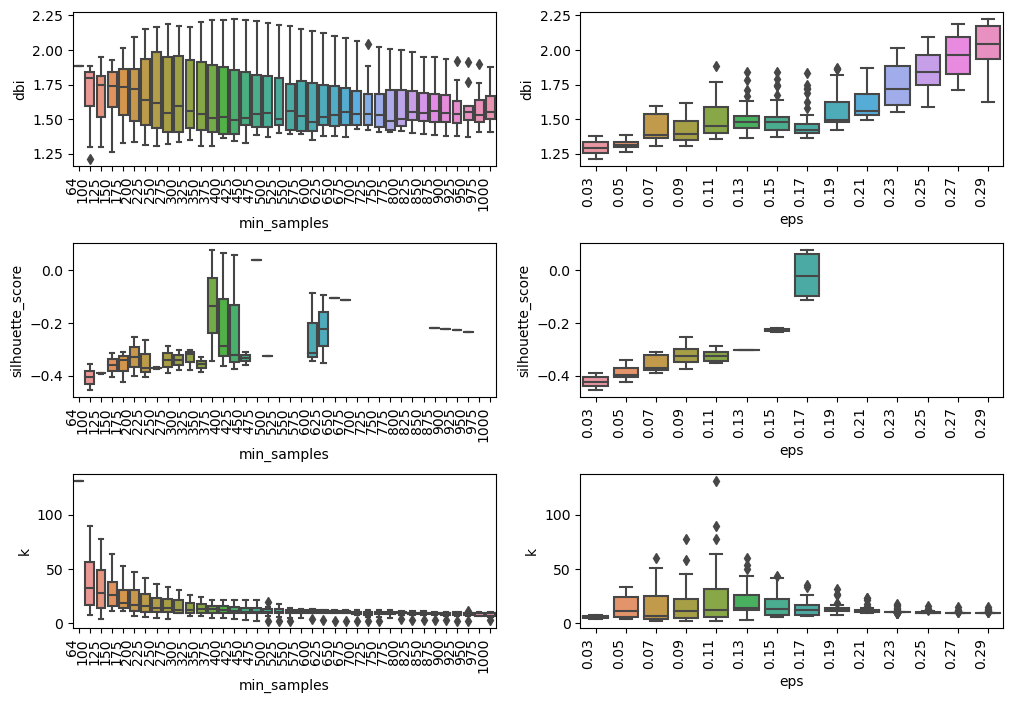

In [228]:
# Relation of settings to scores and k
# Ideal settings, bigger min_samples, smaller eps-- consistent with metric formulation
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8))
_ = fig.subplots_adjust(hspace=0.5)
for i, param in enumerate(["min_samples", "eps"]):
    for j, metric in enumerate(["dbi", "silhouette_score", "k"]):
        ax = axes[j, i]
        _ = sns.boxplot(data=eval_df, x=param, y=metric, ax=ax)
        _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
_ = fig.savefig(f"../results/{grid_key}_boxplot.png")


In [217]:
eval_df["pos_silhouette_score"] = eval_df["silhouette_score"] > 0

eval_df["rank"] = (eval_df["dbi"].rank() + eval_df["silhouette_score"].rank()).rank()
eval_df["top_rank_model"] = eval_df["rank"] <= 10
eval_df.sort_values("rank").head(50)

,key,min_samples,eps,k,dbi,silhouette_score,rank,top_rank_model,pos_silhouette_score
2,"min_samples=100, eps=0.03",100,0.03,8.0,1.2117,-0.455043,1.0,True,False
33,"min_samples=150, eps=0.05",150,0.05,23.0,1.2650,-0.405361,2.0,True,False
18,"min_samples=125, eps=0.05",125,0.05,29.0,1.2987,-0.392114,3.0,True,False
78,"min_samples=225, eps=0.05",225,0.05,6.0,1.3134,-0.404244,4.0,True,False
48,"min_samples=175, eps=0.05",175,0.05,16.0,1.3281,-0.424607,5.0,True,False
3,"min_samples=100, eps=0.05",100,0.05,33.0,1.2960,-0.356640,6.5,True,False
94,"min_samples=250, eps=0.07",250,0.07,21.0,1.3081,-0.368382,6.5,True,False
109,"min_samples=275, eps=0.07",275,0.07,16.0,1.3379,-0.390599,8.0,True,False
124,"min_samples=300, eps=0.07",300,0.07,9.0,1.3358,-0.379014,9.0,True,False
170,"min_samples=375, eps=0.09",375,0.09,15.0,1.3077,-0.344694,10.0,True,False


/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2273308696.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2273308696.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2273308696.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2273308696.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
/var/folders/4l/jbwb4mc545x6m_zf23gyjhm00000gn/T/ipykernel_61031/2273308696.py:9: Us

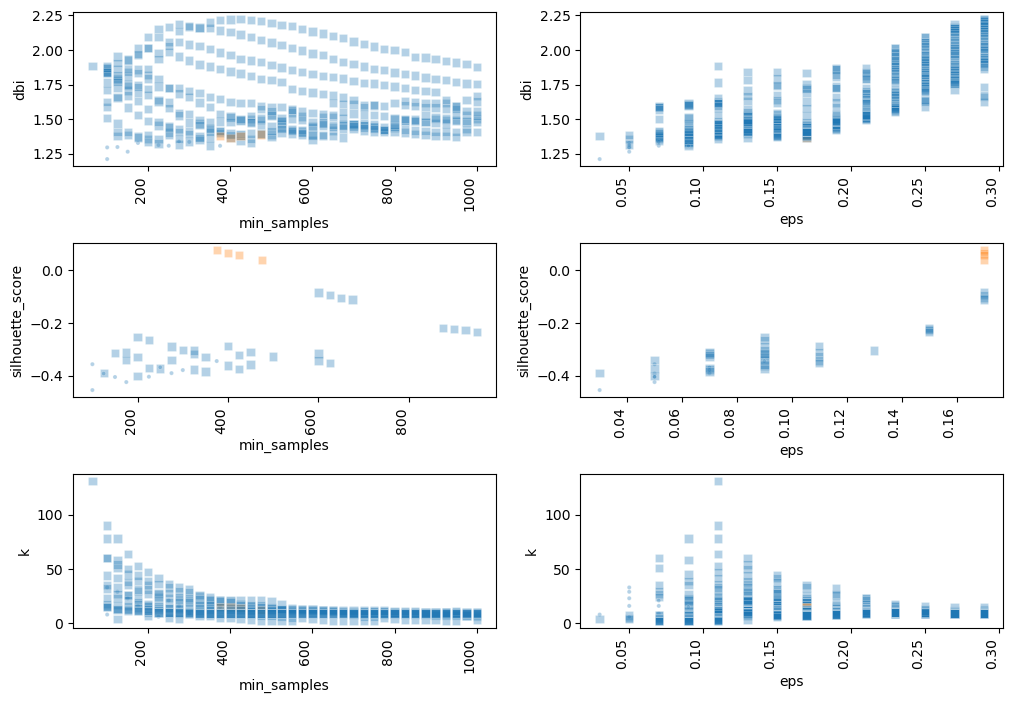

In [229]:
# Relation of settings to scores and k
# Ideal settings, bigger min_samples, smaller eps-- consistent with metric formulation
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,8))
_ = fig.subplots_adjust(hspace=0.5)
for i, param in enumerate(["min_samples", "eps"]):
    for j, metric in enumerate(["dbi", "silhouette_score", "k"]):
        ax = axes[j, i]
        _ = sns.scatterplot(eval_df, y=metric, x=param, hue="pos_silhouette_score", style="top_rank_model", markers={True:".", False:","}, alpha=1/3, ax=ax)
        _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
        _ = ax.get_legend().remove()
_ = fig.savefig(f"../results/{grid_key}_scatter_marked.png")


In [181]:
# Silhouette score has to be positive
eval_df[eval_df["silhouette_score"]>0].sort_values("dbi")

,key,min_samples,eps,k,dbi,silhouette_score
189,"min_samples=400, eps=0.17",400,0.17,15.0,1.3653,0.066442
204,"min_samples=425, eps=0.17",425,0.17,14.0,1.3770,0.059321
174,"min_samples=375, eps=0.17",375,0.17,15.0,1.3789,0.077241
234,"min_samples=475, eps=0.17",475,0.17,12.0,1.3891,0.039352


Considerations:
- Interpretability: number of clusters
- Mathematical Consistency: Davies-Bouldin index
- Cluster Quality: Silhoutte scores